## Imports and Fixed Variables

In [340]:
# Standard Library Imports
from pathlib import Path
from datetime import datetime, timedelta, time
import pytz
import os
import re
from dotenv import load_dotenv

# Third Party Imports
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Alpaca API Imports
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest

import warnings
warnings.filterwarnings("ignore")

# Configure Polars
cfg = pl.Config()
cfg.set_tbl_rows(50)


load_dotenv()
LOAD_API_DATA = True

## Strategy: Pairs Trading

### Strategy Steps and Thoughts
- Evaluate pairs of equities to trade with each other.
- Trade the spread between the prices of these equities using cointegration
- Start by regressing asset A on asset B and determine a hedge factor (try asset B on asset A if results are poor). Volatile Asset = y, Stable Asset = x
    - Hedge Ratio determines the best value to stabilize the residuals between asset prices: 
    - Regression equations: $Pr_A(t) = k\cdot Pr_B(t) + \epsilon_t, \ \ \epsilon = Pr_A(t) - k Pr_B(t)$
    - Assumes that one asset is less noisy than the other asset which in reality is not true.
- Calculate the Z-score of the price difference between the assets and trade based on the magnitude and direction of the Z-score: $Z-score = \frac{Spread_t - \mu}{\sigma}$
    - Z = +2 → unusually wide
    - Z = 0 → normal
    - Z = −2 → unusually tight

### Ideal Conditions for Pair Equities
- Mean-reverting spread
- Low variance
- Fast reversion
- Good hedge ratio produces a spread with the following properties
    - **Stationarity**: Constant mean with no drift over time, this can be tested with the augmented Dickey-Fuller test. If the spread is not stationary, do not trade it.
    - **Fast mean reversion**: Deviations that close quickly which can be measured by half-life and speed of adjustment. Shorter half-life gives better capital efficiency.
    - **Stability over time**: The hedge ratio should not swing wildly across windows or flip signs. This would suggest structural instability or regime changes are occuring.
    - **Good Market Interpretation**: Good hedge ratios often align with fundamentals like relative market caps, betas, or exposure. Hedge ratios should not be extremely large or tiny and should not flip signs often.

### Better Ways to Estimate Hedge Ratio
1. Total Least Squares / Orthogonal Regression
    - Treats both assets symmetrically
    - More stable hedge ratios
2. Johansen Cointegration
    - Finds hedge ratios in a multivariate setting
    - More statistically rigorous
3. Rolling Regression
    - Allows hedge ratio to adapt over time
4. Kalman Filter
    - Hedge ratio evolves smoothly
    - Very popular in professional implementations

### Pairs for Initial Research
- Visa (V) – Mastercard (MA)
- American Express (AXP) – Discover (DFS)
- Exxon (XOM) – Chevron (CVX)
- Shell (SHEL) – BP (BP)
- NVIDIA (NVDA) – AMD (AMD)
- Alphabet (GOOGL) – GOOG
- Berkshire Hathaway (BRK.A) – BRK.B
- Delta (DAL) – United (UAL)
- JPMorgan (JPM) – Bank of America (BAC)
- Home Depot (HD) – Lowe’s (LOW)

### Mission Statement
Goal is not to find the best pair that will make money, the goal is to learn to detect when relationship is real, stable, and tradable.

### Stock Data Query

In [4]:
data_path = Path.cwd() / "data/external" / "bars_data_2022-07-01_to_2025-12-13.csv"

api_key = os.getenv("APCA-API-KEY-ID")
secret_key = os.getenv("APCA-API-SECRET-KEY")

client = StockHistoricalDataClient(
    api_key=api_key,
    secret_key=secret_key,
)

ticker_symbols = [
    "V",
    "MA",
    "AXP",
    "DFS",
    "XOM",
    "CVX",
    "SHEL",
    "BP",
    "NVDA",
    "AMD",
    "GOOGL",
    "GOOG",
    "BRK.A",
    "BRK.B",
    "DAL",
    "UAL",
    "JPM",
    "BAC",
    "HD",
    "LOW",
]

request_params = StockBarsRequest(
    symbol_or_symbols=ticker_symbols,
    timeframe=TimeFrame.Hour,
    start="2022-07-01",
    end="2024-12-15",  # Explicit end date
    adjustment='all'  # Handle splits/dividends consistently
)

if LOAD_DATA:
    df_bars = pd.read_csv(data_path)
else:
    bars = client.get_stock_bars(request_params).df
    # Create a complete datetime index
    full_index = pd.date_range(
        start="2022-07-01",
        end="2024-12-15",
        freq='H',
        tz='America/New_York'
    )

    # Filter for market hours (9:30 AM - 4 PM ET, weekdays)
    full_index = full_index[
        (full_index.hour >= 9) &
        (full_index.hour < 16) &
        (full_index.dayofweek < 5)
    ]
    # Convert to UTC to match Alpaca data
    full_index = full_index.tz_convert('UTC')

    # Reindex each symbol to the full index
    aligned_data = {}
    for symbol in ticker_symbols:
        symbol_data = bars.xs(symbol, level='symbol')
        aligned_data[symbol] = symbol_data.reindex(full_index, method='ffill')  # or method=None for NaN

    # Convert to DataFrame with MultiIndex (same structure as original)
    df_bars = pd.concat(
        aligned_data,
        names=['symbol', 'timestamp']
    ).reset_index()

df_bars


Unnamed: 0 symbol                  timestamp    open    high     low  \
0               0      V  2022-07-01 13:00:00+00:00  191.71  192.90  189.68   
1               1      V  2022-07-01 14:00:00+00:00  192.41  192.89  189.58   
2               2      V  2022-07-01 15:00:00+00:00  189.89  191.53  189.68   
3               3      V  2022-07-01 16:00:00+00:00  190.62  191.81  190.49   
4               4      V  2022-07-01 17:00:00+00:00  191.07  192.28  190.68   
...           ...    ...                        ...     ...     ...     ...   
89735       89735    LOW  2024-12-13 16:00:00+00:00  258.79  259.41  258.36   
89736       89736    LOW  2024-12-13 17:00:00+00:00  259.03  259.03  256.94   
89737       89737    LOW  2024-12-13 18:00:00+00:00  257.43  258.06  257.36   
89738       89738    LOW  2024-12-13 19:00:00+00:00  257.56  257.75  256.92   
89739       89739    LOW  2024-12-13 20:00:00+00:00  257.32  257.41  256.93   

        close    volume  trade_count        vwap  
0      192.43  812474.0      12202.0  191.439461  
1      189.95  531290.0      12710.0  190.767388  
2      190.58  471609.0       9386.0  190.669204  
3      191.10  279125.0       5788.0  191.195637  
4      192.04  304338.0       6458.0  191.497722  
...       ...       ...          ...         ...  
89735  259.03  160963.0       4355.0  258.853826  
89736  257.35  194106.0       5138.0  257.935328  
89737  257.58  151169.0       4556.0  257.688419  
89738  257.26  111300.0       4390.0  257.274738  
89739  257.14  372183.0      10805.0  257.216762  

[89740 rows x 10 columns]

### Initial Stock Pairs Research

------------------------------
Pairs: V vs MA
------------------------------
ADF Statistic: -4.77591896563171
p-value: 6.045803034986516e-05
Critical Values:
1%: -3.4319131425147202
5%: -2.8622307104041673
10%: -2.5671376710574165

Half-life of Mean Reversion: 56.39005535177904
Number of Trades: 37


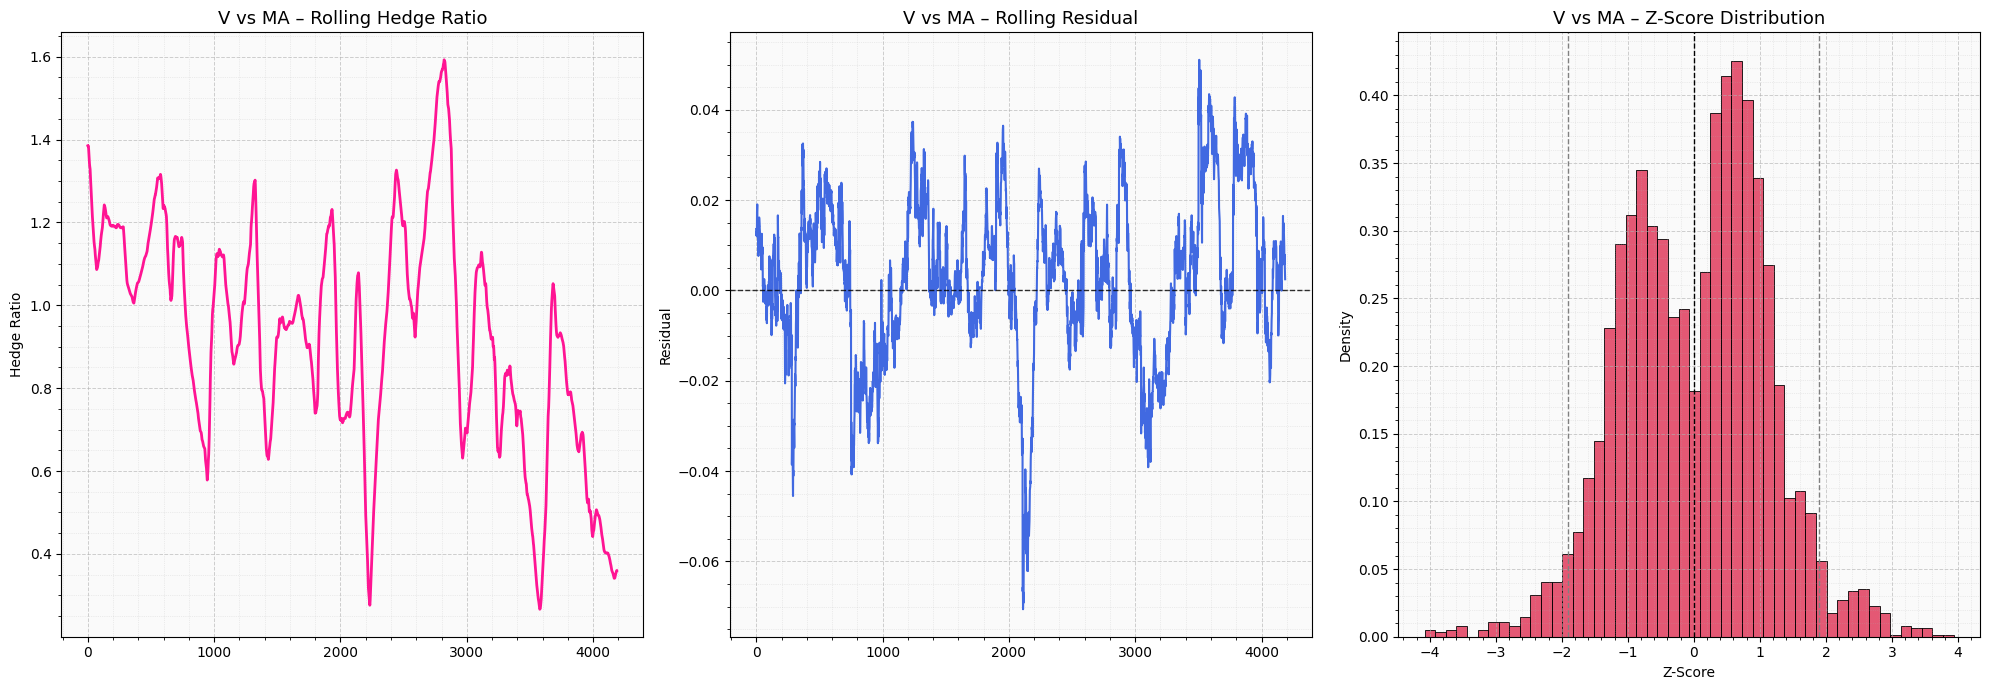

------------------------------
Pairs: AXP vs DFS
------------------------------
ADF Statistic: -5.8296358632125616
p-value: 4.003177566252734e-07
Critical Values:
1%: -3.4319127689531217
5%: -2.8622305453807453
10%: -2.56713758320661

Half-life of Mean Reversion: 42.93943635076008
Number of Trades: 40


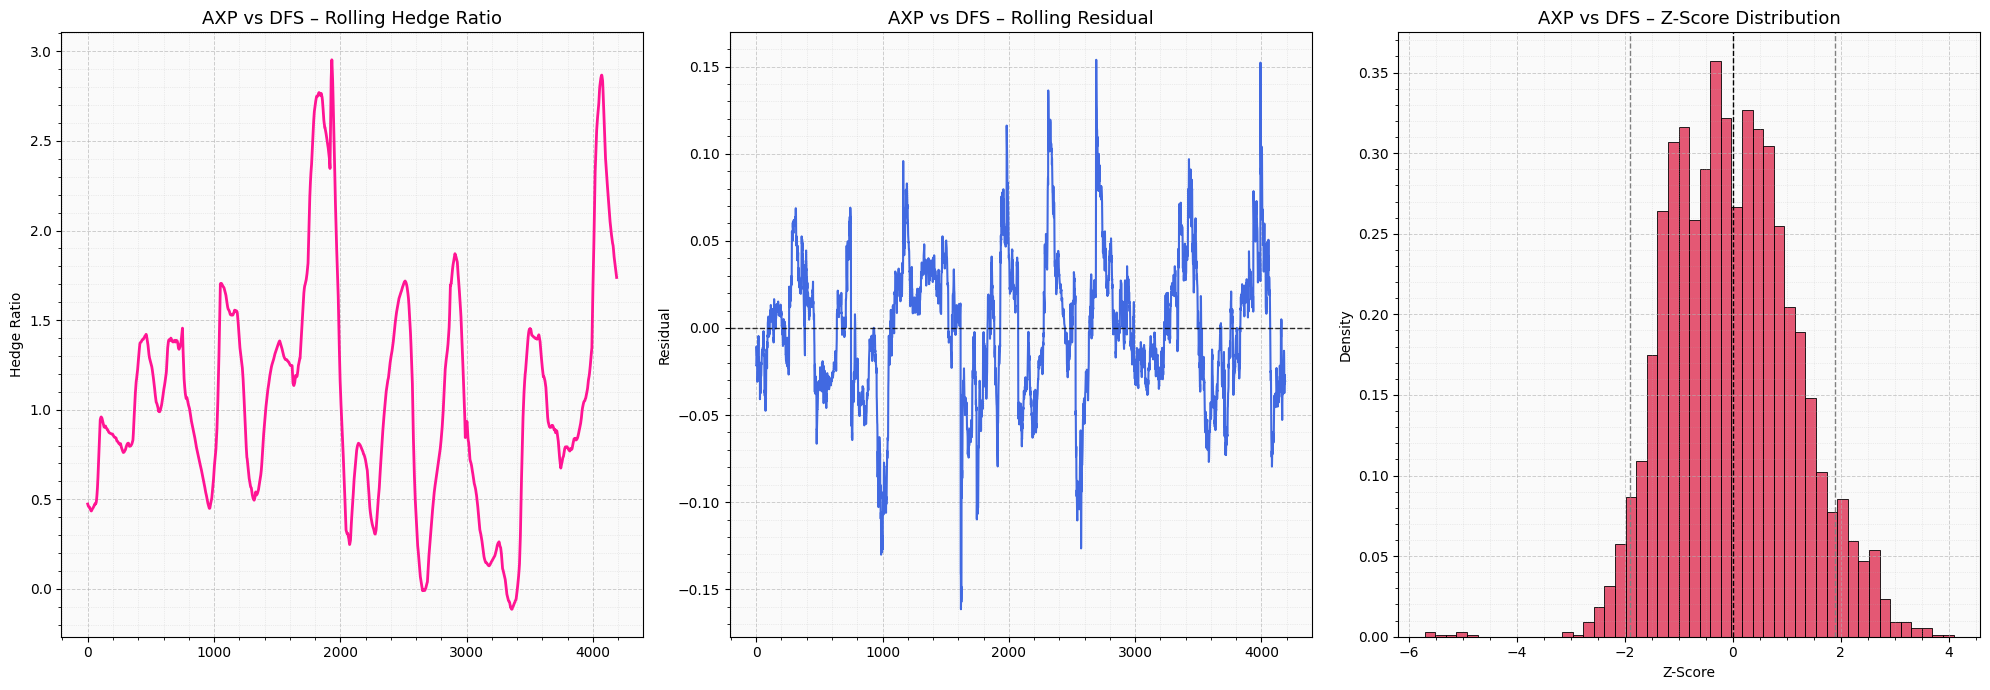

------------------------------
Pairs: XOM vs CVX
------------------------------
ADF Statistic: -4.408264884050414
p-value: 0.0002869935017686264
Critical Values:
1%: -3.4319127689531217
5%: -2.8622305453807453
10%: -2.56713758320661

Half-life of Mean Reversion: 74.99522830590554
Number of Trades: 34


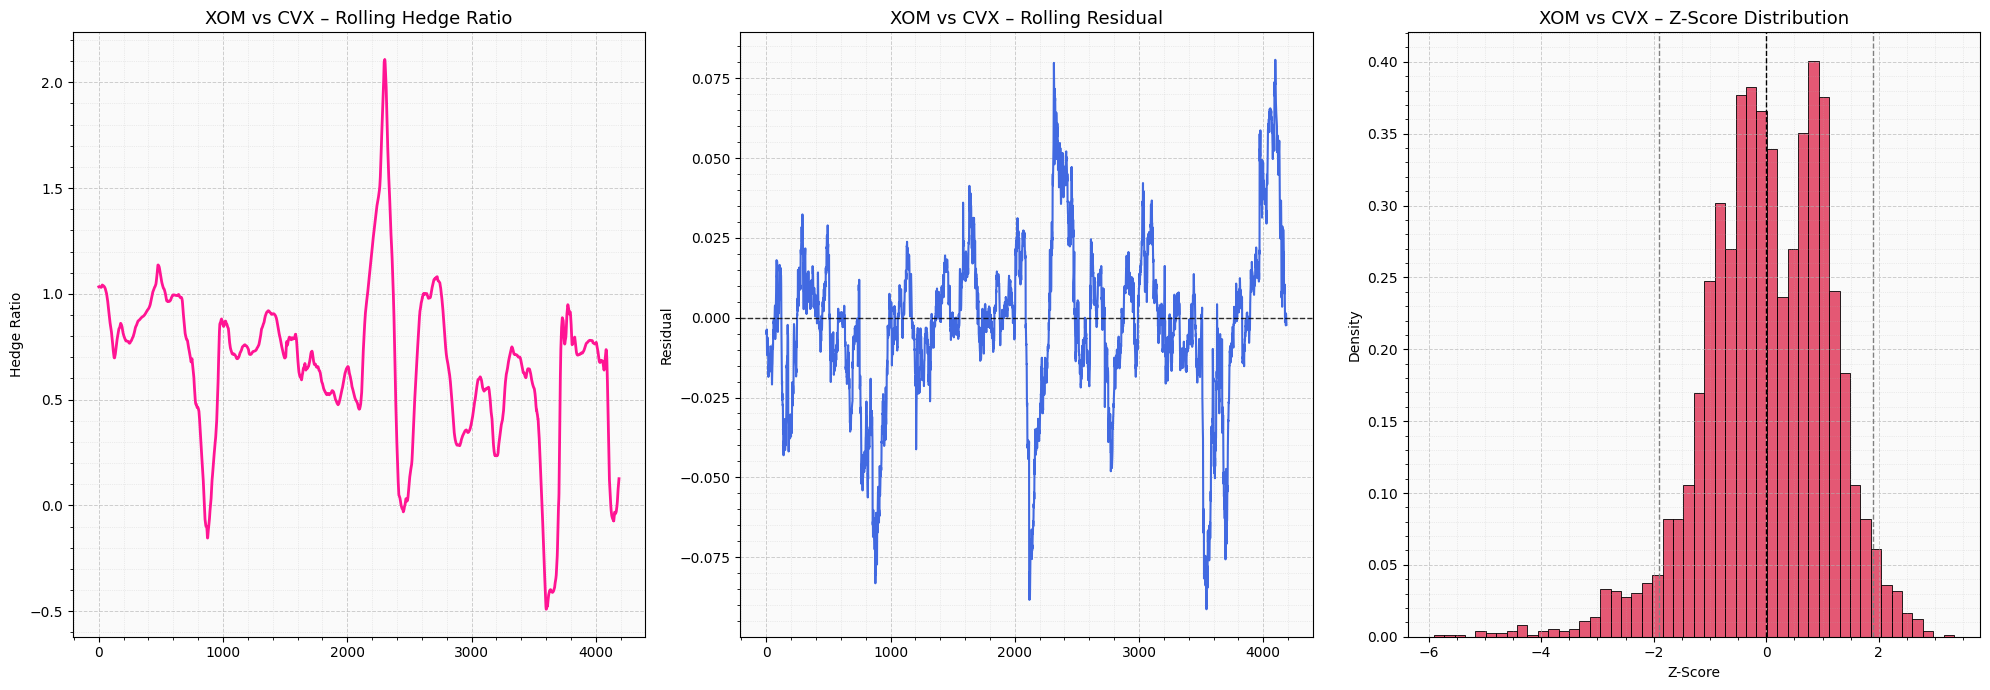

------------------------------
Pairs: SHEL vs BP
------------------------------
ADF Statistic: -5.130492649167925
p-value: 1.216908236331003e-05
Critical Values:
1%: -3.4319157624548438
5%: -2.8622318677802716
10%: -2.5671382871908053

Half-life of Mean Reversion: 59.54658592193458
Number of Trades: 25


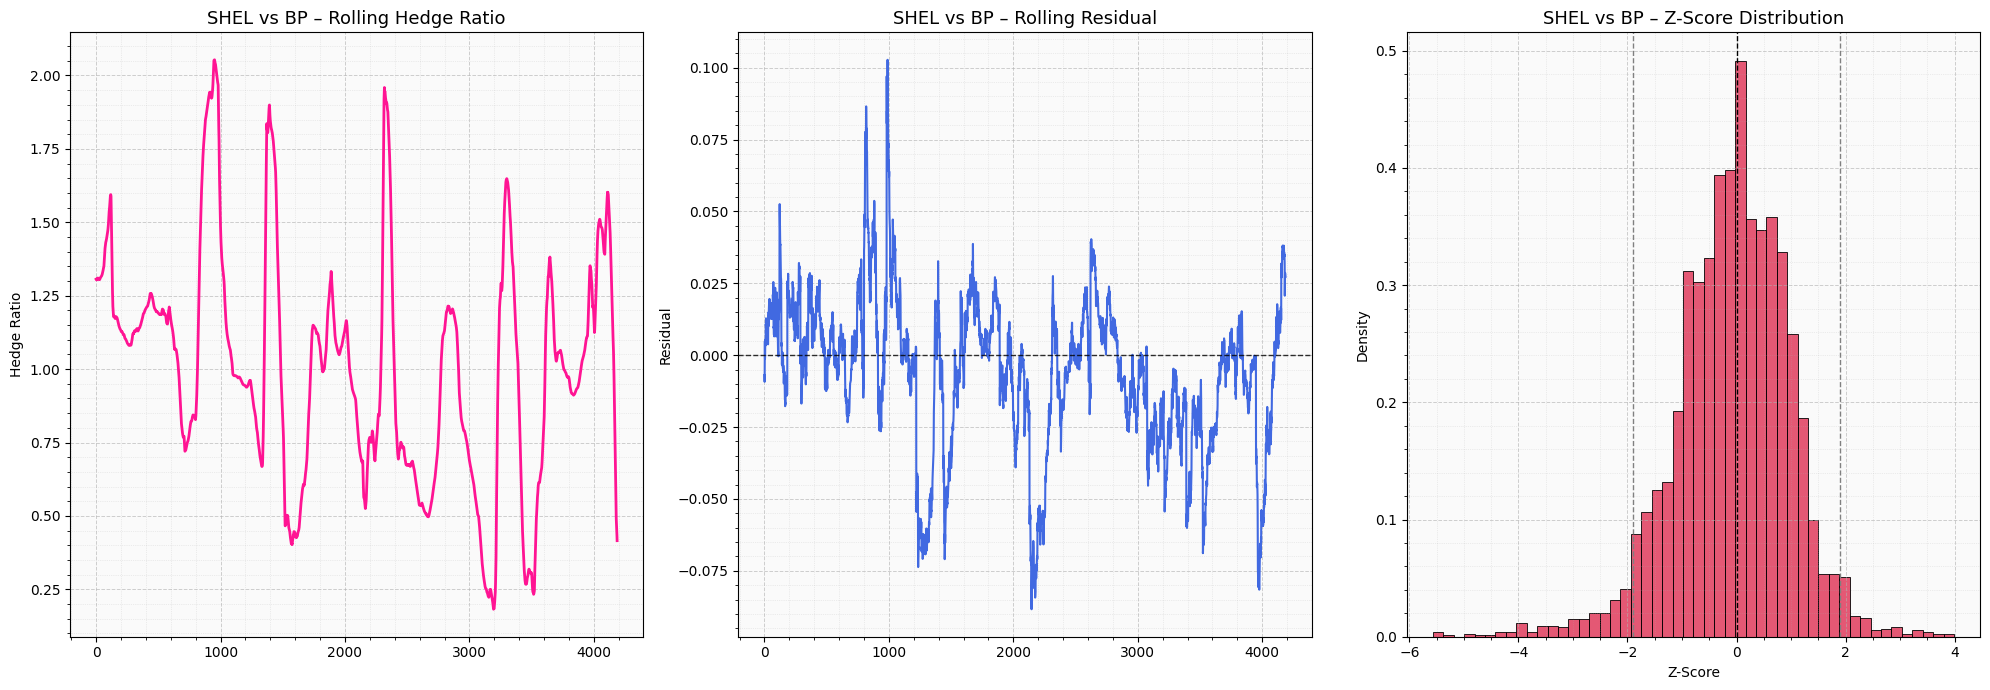

------------------------------
Pairs: NVDA vs AMD
------------------------------
ADF Statistic: -4.737531400694828
p-value: 7.150228741979823e-05
Critical Values:
1%: -3.431913516254953
5%: -2.8622308755064814
10%: -2.5671377589502247

Half-life of Mean Reversion: 67.12267182403586
Number of Trades: 36


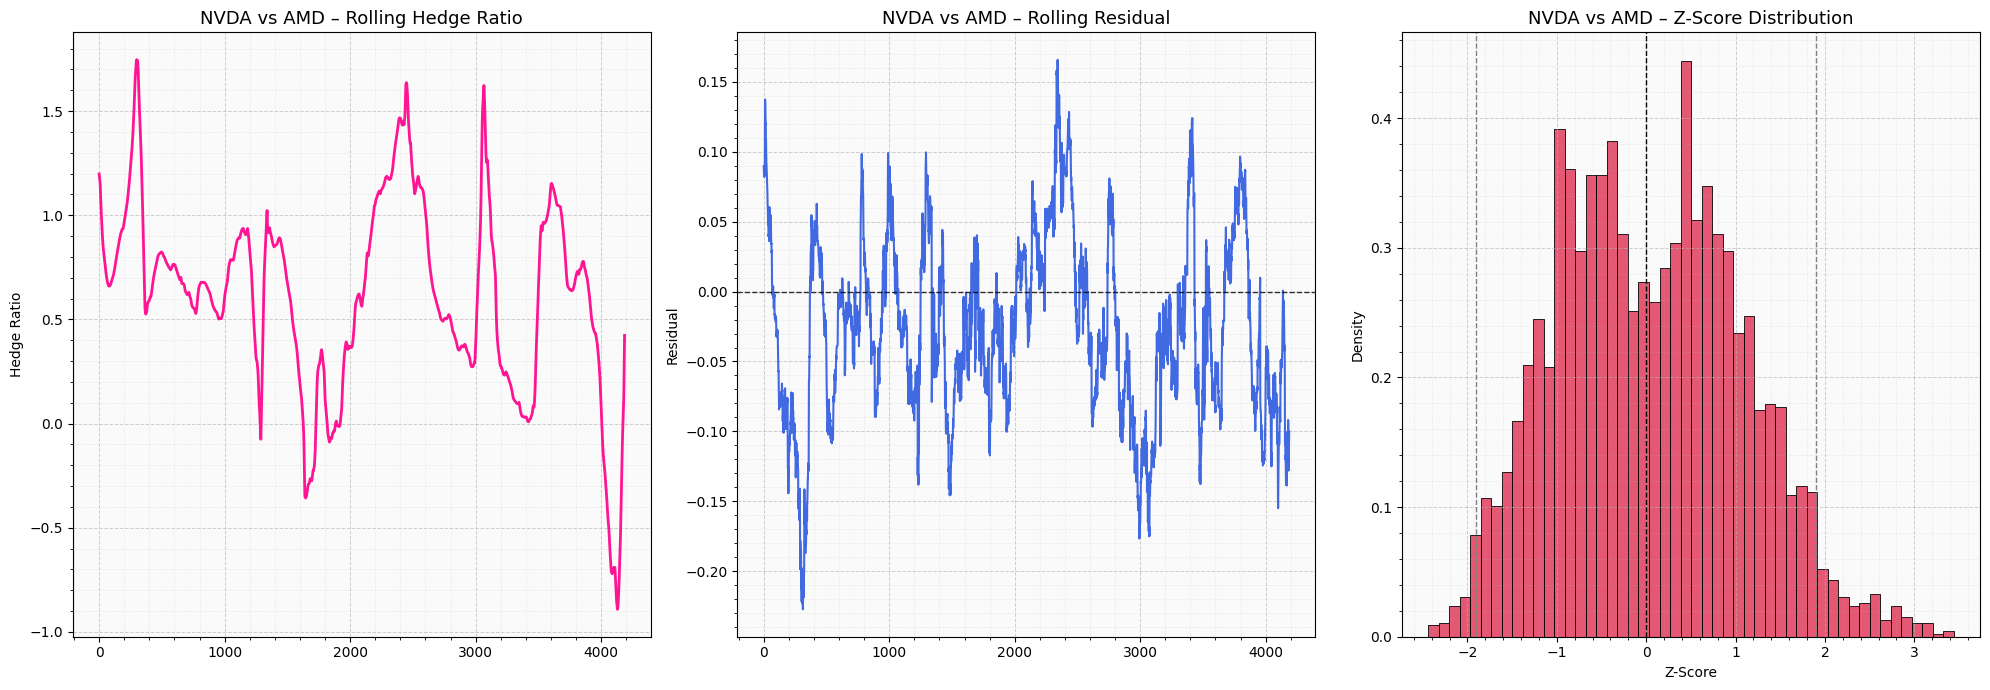

------------------------------
Pairs: GOOGL vs GOOG
------------------------------
ADF Statistic: -5.452702394091735
p-value: 2.6227428313736723e-06
Critical Values:
1%: -3.4319206514309863
5%: -2.8622340275155196
10%: -2.5671394369342013

Half-life of Mean Reversion: 18.264761623791756
Number of Trades: 41


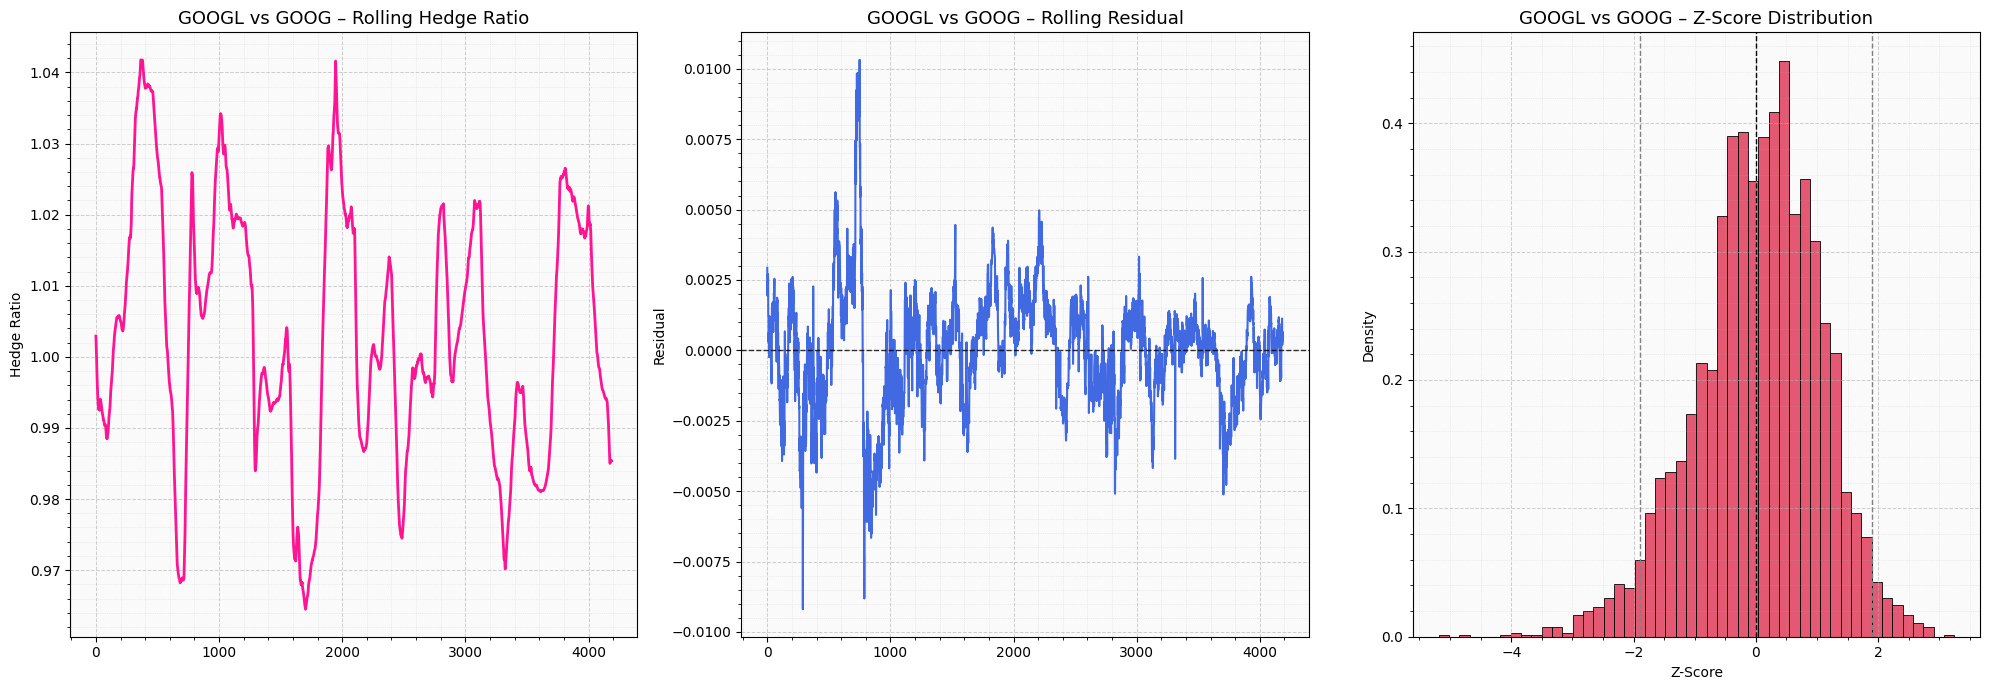

------------------------------
Pairs: BRK.A vs BRK.B
------------------------------
ADF Statistic: -6.1621063683844906
p-value: 7.132817241917039e-08
Critical Values:
1%: -3.431924054030508
5%: -2.8622355306326717
10%: -2.5671402371247747

Half-life of Mean Reversion: 9.175080940751753
Number of Trades: 61


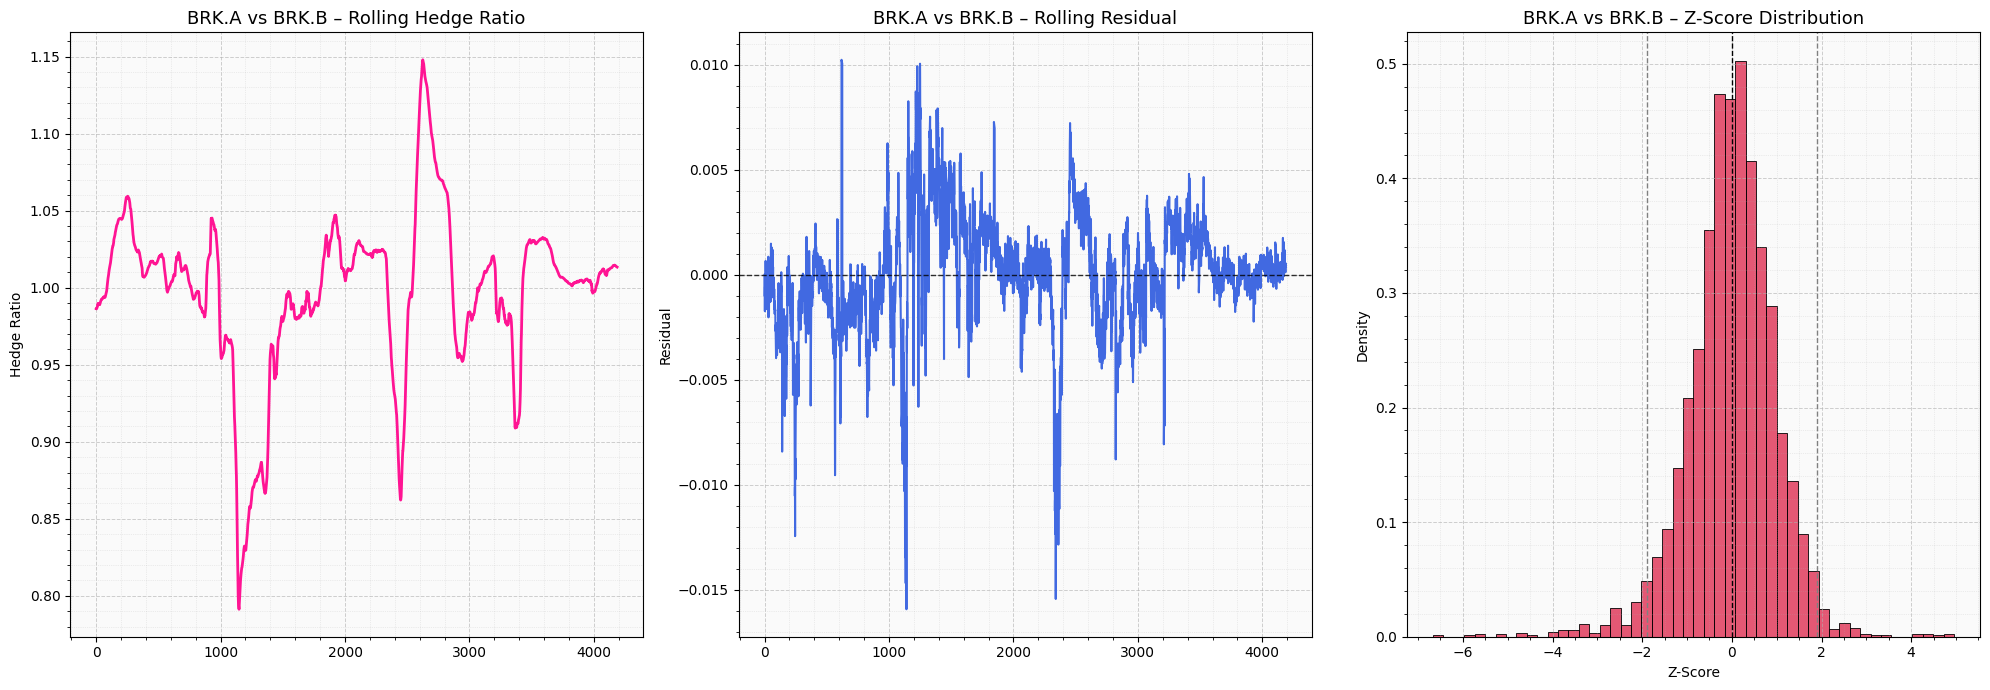

------------------------------
Pairs: DAL vs UAL
------------------------------
ADF Statistic: -7.449888752605906
p-value: 5.707377801239027e-11
Critical Values:
1%: -3.4319180151179545
5%: -2.862232862908481
10%: -2.5671388169510743

Half-life of Mean Reversion: 40.30056263885703
Number of Trades: 49


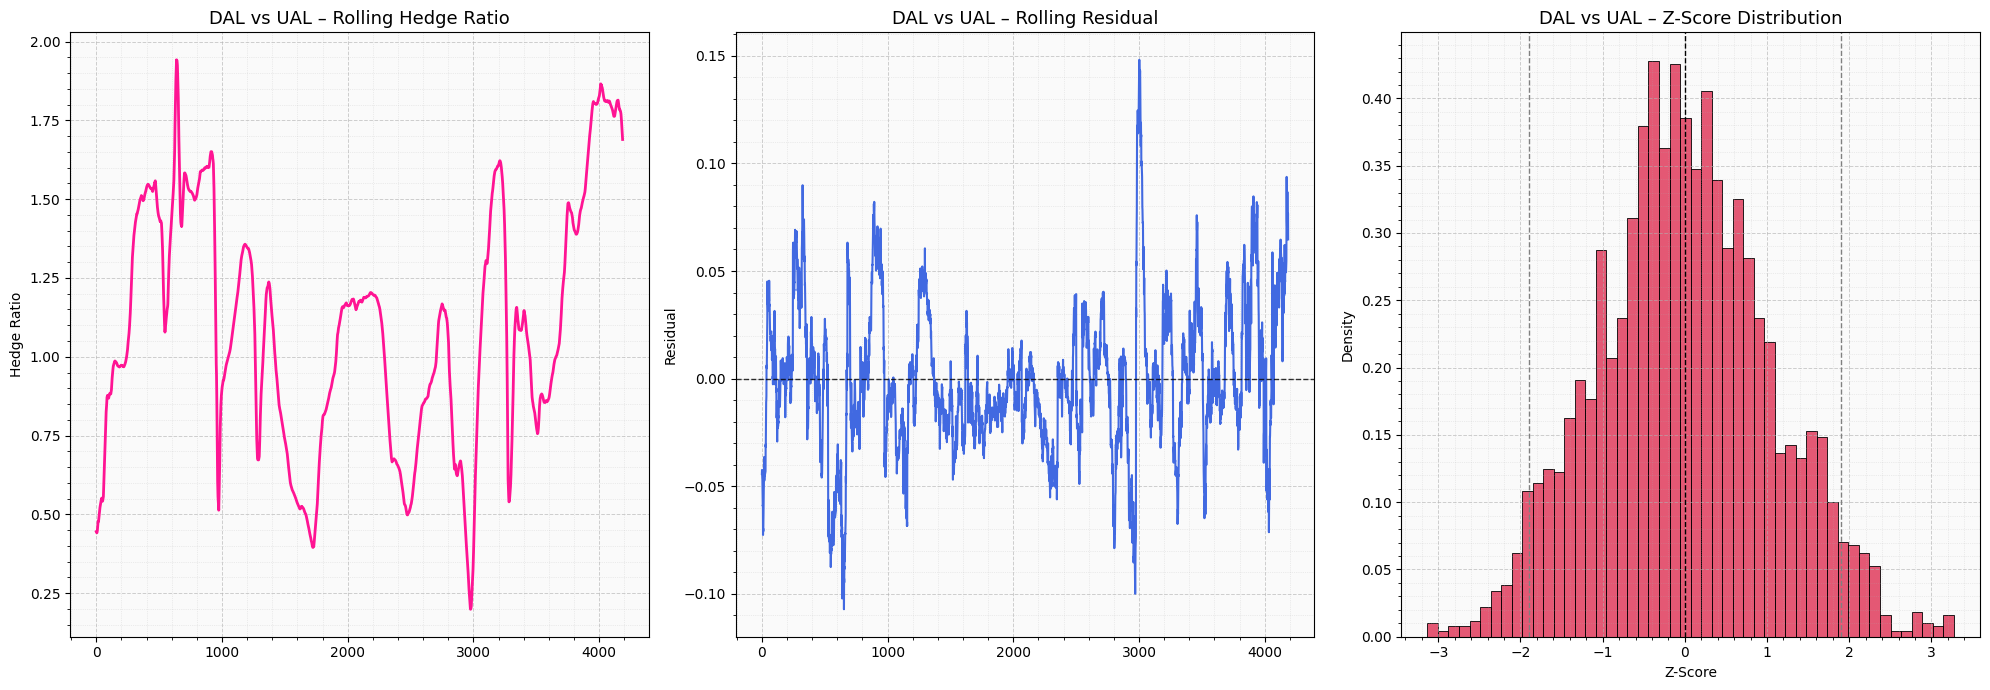

------------------------------
Pairs: JPM vs BAC
------------------------------
ADF Statistic: -4.482761957643747
p-value: 0.00021123435186433056
Critical Values:
1%: -3.431915387640113
5%: -2.862231702203415
10%: -2.5671381990453517

Half-life of Mean Reversion: 64.40105209020109
Number of Trades: 33


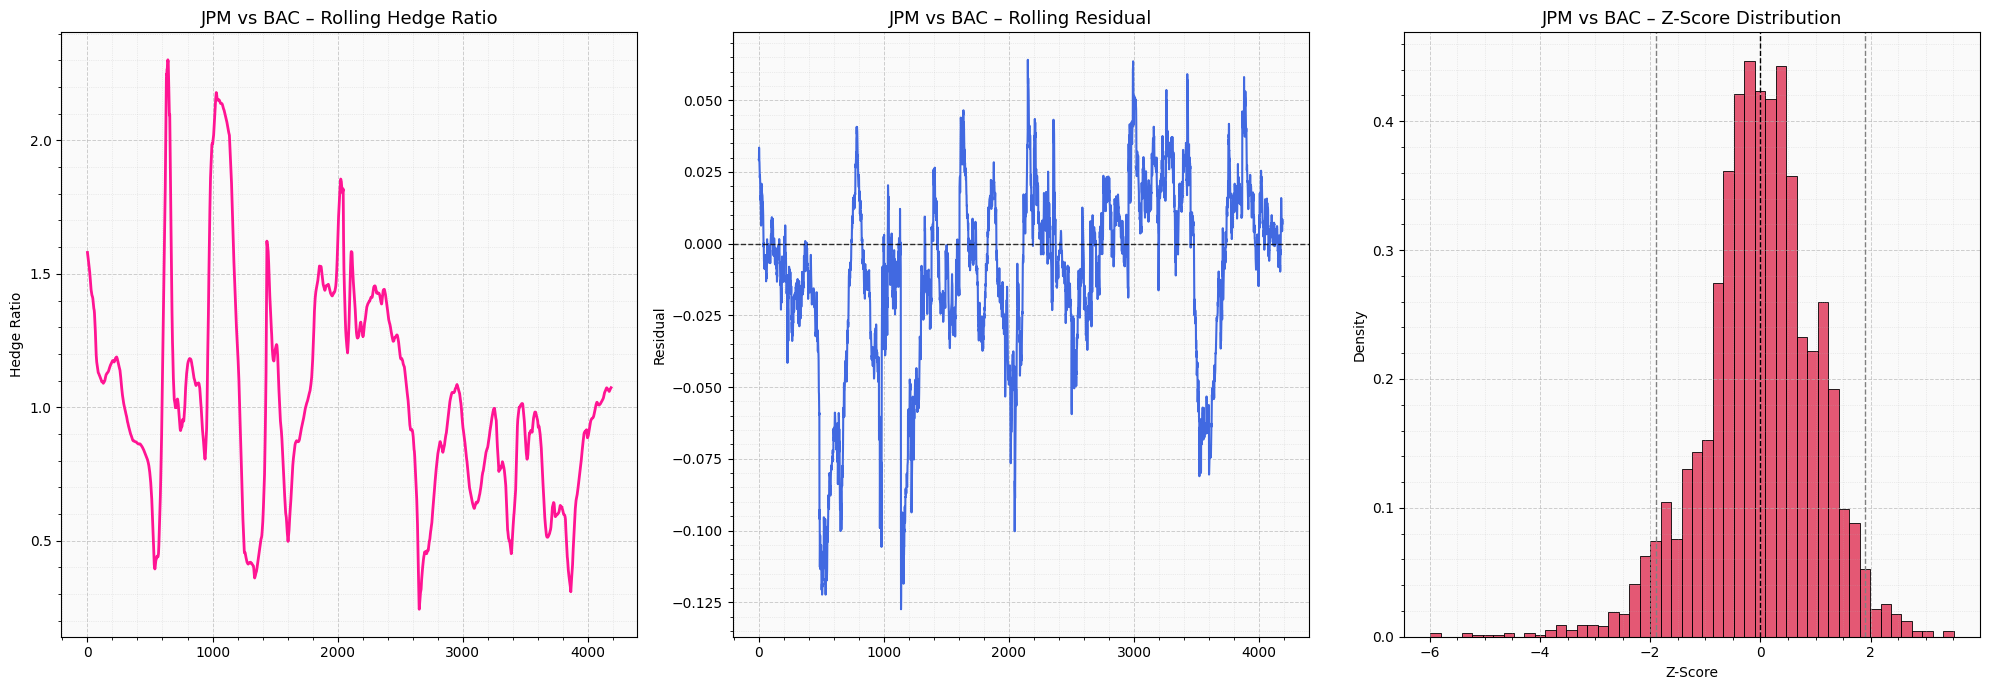

------------------------------
Pairs: HD vs LOW
------------------------------
ADF Statistic: -5.281733655447448
p-value: 5.97343049881032e-06
Critical Values:
1%: -3.431913516254953
5%: -2.8622308755064814
10%: -2.5671377589502247

Half-life of Mean Reversion: 53.284141953656516
Number of Trades: 37


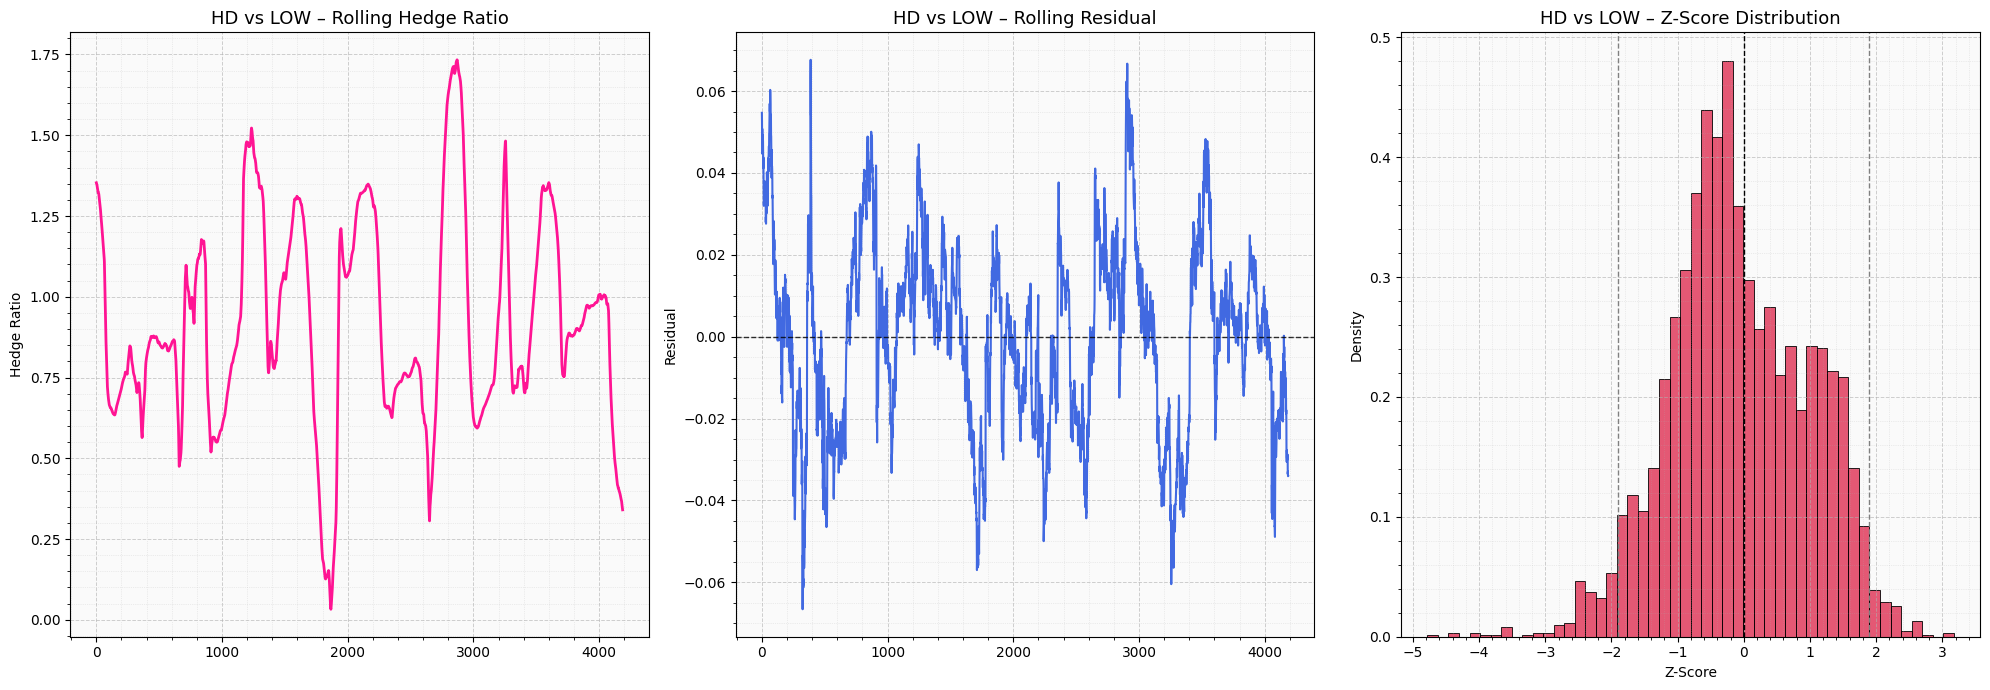

In [28]:
window_length = 300
upper = 1.90
lower = -1.90

equity_pairs = [
    ["V","MA"],
    ["AXP","DFS"],
    ["XOM","CVX"],
    ["SHEL","BP"],
    ["NVDA","AMD"],
    ["GOOGL","GOOG"],
    ["BRK.A","BRK.B"],
    ["DAL","UAL"],
    ["JPM","BAC"],
    ["HD","LOW"],
]

for pair in equity_pairs:

    A = df_bars.loc[df_bars["symbol"] == pair[0], "close"].values
    B = df_bars.loc[df_bars["symbol"] == pair[1], "close"].values

    if len(A) != len(B):
        continue

    # log prices (strongly recommended)
    x = np.log(A)
    y = np.log(B)

    # rolling windows (view, not copy)
    x_win = np.lib.stride_tricks.sliding_window_view(x, window_length)
    y_win = np.lib.stride_tricks.sliding_window_view(y, window_length)

    hedge_ratios = np.empty(len(x_win))
    residuals = np.empty(len(x_win))

    for i, (wx, wy) in enumerate(zip(x_win, y_win)):

        x_mean = wx.mean()
        y_mean = wy.mean()

        cov_xy = np.mean((wx - x_mean) * (wy - y_mean))
        var_x = np.mean((wx - x_mean) ** 2)

        k = cov_xy / var_x
        alpha = y_mean - k * x_mean

        hedge_ratios[i] = k

        # compute residual ONLY at end of window (out-of-sample)
        residuals[i] = y[i + window_length - 1] - (alpha + k * x[i + window_length - 1])

    print("-"*30)
    print(f"Pairs: {pair[0]} vs {pair[1]}")
    print("-"*30)
    stationarity_test = adfuller(residuals)
    print(f'ADF Statistic: {stationarity_test[0]}')
    print(f'p-value: {stationarity_test[1]}')
    print('Critical Values:')
    for key, value in stationarity_test[4].items():
        print(f'{key}: {value}')
    print()

    delta = residuals[1:] - residuals[:-1]
    lagged = residuals[:-1]

    # Ensures rolling mean does not have lookahead bias by using entire residuals for mean and std calc
    rolling_mean = np.convolve(residuals, np.ones(window_length)/window_length, mode="valid")
    rolling_std = np.sqrt(
        np.convolve((residuals - rolling_mean.mean())**2,
                    np.ones(window_length)/window_length,
                    mode="valid")
    )
    z_scores = (residuals[window_length-1:] - rolling_mean) / rolling_std


    beta = np.polyfit(lagged, delta, 1)[0]
    half_life = -np.log(2) / beta
    print(f"Half-life of Mean Reversion: {half_life}")

    short_entries = (z_scores[:-1] <= upper) & (z_scores[1:] > upper)
    long_entries  = (z_scores[:-1] >= lower) & (z_scores[1:] < lower)
    num_trades = np.sum(short_entries) + np.sum(long_entries)
    exit_cross = (z_scores[:-1] * z_scores[1:] < 0)
    print(f"Number of Trades: {num_trades}")

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    def style_axis(ax):
        ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.6)
        ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.4)
        ax.minorticks_on()
        ax.tick_params(axis="both", which="both", labelsize=10)
        ax.set_facecolor("#fafafa")

    # --- Rolling Hedge Ratio ---
    axes[0].plot(hedge_ratios, color="deeppink", linewidth=2)
    axes[0].set_title(f"{pair[0]} vs {pair[1]} – Rolling Hedge Ratio", fontsize=13)
    axes[0].set_ylabel("Hedge Ratio")
    style_axis(axes[0])

    # --- Rolling Residual ---
    axes[1].plot(residuals, color="royalblue", linewidth=1.5)
    axes[1].axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.8)
    axes[1].set_title(f"{pair[0]} vs {pair[1]} – Rolling Residual", fontsize=13)
    axes[1].set_ylabel("Residual")
    style_axis(axes[1])

    # --- Z-score Distribution ---
    sns.histplot(
        z_scores,
        ax=axes[2],
        bins=50,
        color="crimson",
        alpha=0.7,
        stat="density"
    )

    axes[2].axvline(0, color="black", linestyle="--", linewidth=1)
    axes[2].axvline(upper, color="gray", linestyle="--", linewidth=1)
    axes[2].axvline(lower, color="gray", linestyle="--", linewidth=1)

    axes[2].set_title(f"{pair[0]} vs {pair[1]} – Z-Score Distribution", fontsize=13)
    axes[2].set_xlabel("Z-Score")
    style_axis(axes[2])

    plt.tight_layout()
    plt.show()


In [57]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
    symbol_or_symbols=["SOL/USD", "ETH/USD"],
    timeframe=TimeFrame.Hour,
    start=datetime(2022, 7, 1),
    end=datetime(2025, 12, 13),
)

bars_crypto = client.get_crypto_bars(request_params)

# convert to dataframe
df_crypto = bars_crypto.df.reset_index()
df_crypto

symbol                 timestamp       open      high        low  \
0      ETH/USD 2022-07-01 00:00:00+00:00  1070.3000  1119.210  1049.2500   
1      ETH/USD 2022-07-01 01:00:00+00:00  1095.0000  1101.430  1083.9600   
2      ETH/USD 2022-07-01 02:00:00+00:00  1095.6600  1106.000  1089.1000   
3      ETH/USD 2022-07-01 03:00:00+00:00  1090.9200  1091.900  1052.9500   
4      ETH/USD 2022-07-01 04:00:00+00:00  1052.6900  1063.050  1043.7000   
...        ...                       ...        ...       ...        ...   
50436  SOL/USD 2025-12-12 20:00:00+00:00   131.1700   132.100   130.9100   
50437  SOL/USD 2025-12-12 21:00:00+00:00   131.5295   132.240   131.3115   
50438  SOL/USD 2025-12-12 22:00:00+00:00   131.9150   132.895   131.9150   
50439  SOL/USD 2025-12-12 23:00:00+00:00   133.0060   133.123   132.2165   
50440  SOL/USD 2025-12-13 00:00:00+00:00   132.3400   132.750   132.3400   

           close       volume  trade_count         vwap  
0      1093.2200  4390.764620       5312.0  1083.711619  
1      1095.1800  2503.310200       3377.0  1091.447388  
2      1091.1600  1232.364780       2253.0  1095.286380  
3      1053.4500  1862.170530       2678.0  1074.614779  
4      1048.5900  2168.770940       2570.0  1050.397813  
...          ...          ...          ...          ...  
50436   131.5830    25.236931         14.0   131.633117  
50437   131.8700     0.291454          4.0   132.191307  
50438   132.7520     0.030000          1.0   132.895000  
50439   132.2485     0.568275          7.0   133.006366  
50440   132.6200     0.060731          1.0   132.600000  

[50441 rows x 9 columns]

------------------------------
Pairs: BTC/USD vs ETH/USD
------------------------------
ADF Statistic: -9.203750393831497
p-value: 1.9701123915325938e-15
Critical Values:
1%: -3.4305699752675656
5%: -2.861637223089821
10%: -2.5668217488894616

Half-life of Mean Reversion: 120.5442880970962
Number of Trades: 206


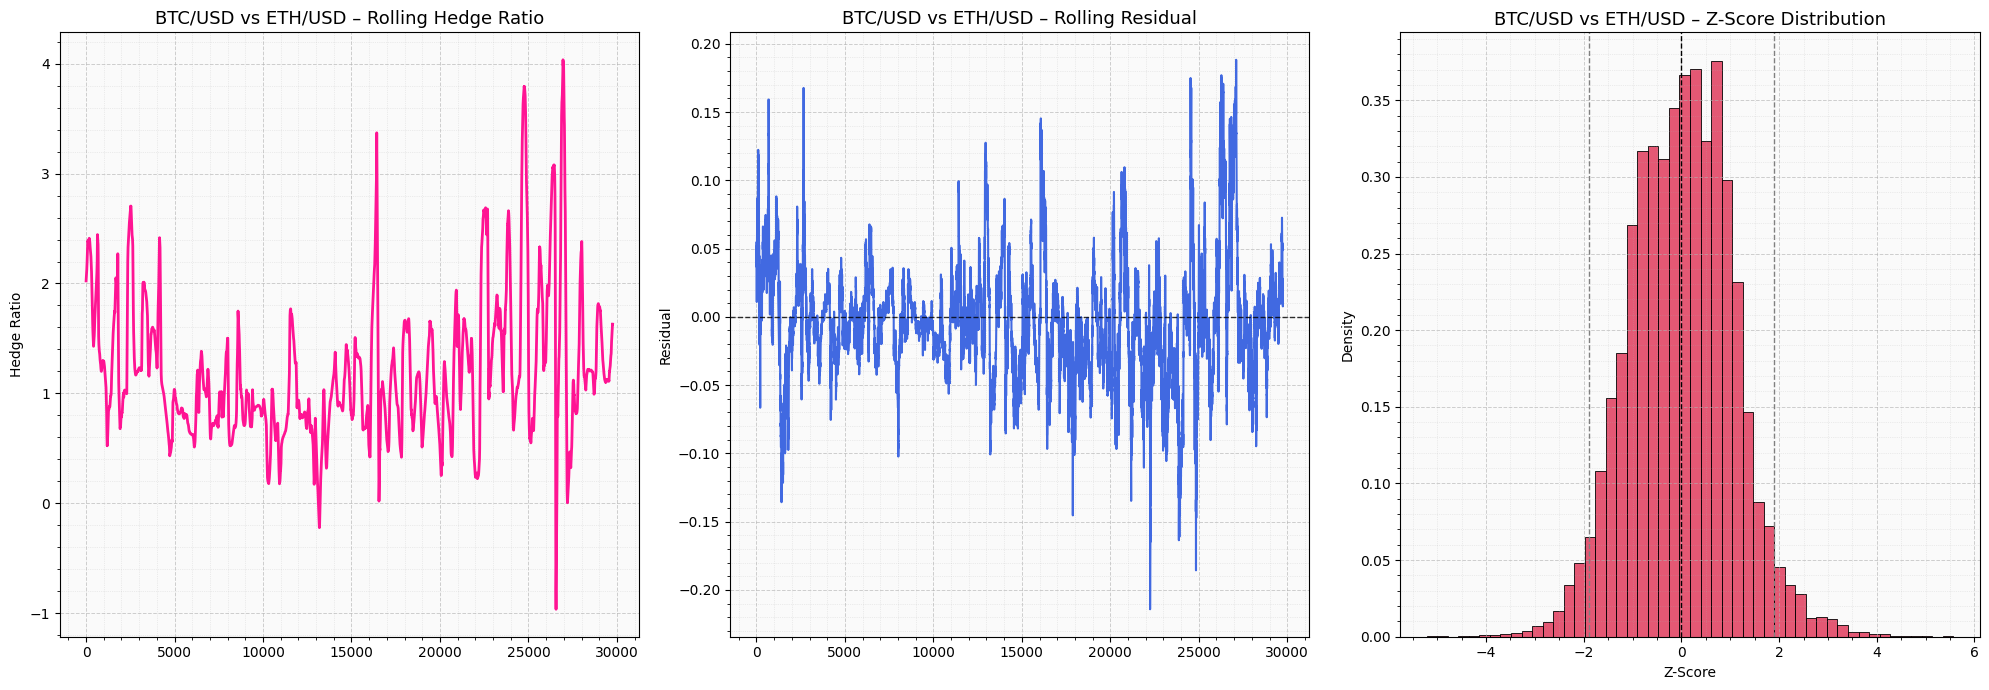

In [56]:
window_length = 500
upper = 1.90
lower = -1.90

equity_pairs = [
    ["BTC/USD","ETH/USD"],
]

for pair in equity_pairs:

    stock_A = df_crypto.loc[df_crypto["symbol"] == pair[0], :]
    stock_B = df_crypto.loc[df_crypto["symbol"] == pair[1], :]

    if len(stock_A) != len(stock_B):
        common_times = stock_A["timestamp"].isin(stock_B["timestamp"])
        A_filter = stock_A[common_times]
        B_filter = stock_B[stock_B["timestamp"].isin(stock_A["timestamp"])]

        A = A_filter["close"].values
        B = B_filter["close"].values


    # log prices (strongly recommended)
    x = np.log(A)
    y = np.log(B)

    # rolling windows (view, not copy)
    x_win = np.lib.stride_tricks.sliding_window_view(x, window_length)
    y_win = np.lib.stride_tricks.sliding_window_view(y, window_length)

    hedge_ratios = np.empty(len(x_win))
    residuals = np.empty(len(x_win))

    for i, (wx, wy) in enumerate(zip(x_win, y_win)):

        x_mean = wx.mean()
        y_mean = wy.mean()

        cov_xy = np.mean((wx - x_mean) * (wy - y_mean))
        var_x = np.mean((wx - x_mean) ** 2)

        k = cov_xy / var_x
        alpha = y_mean - k * x_mean

        hedge_ratios[i] = k

        # compute residual ONLY at end of window (out-of-sample)
        residuals[i] = y[i + window_length - 1] - (alpha + k * x[i + window_length - 1])

    print("-"*30)
    print(f"Pairs: {pair[0]} vs {pair[1]}")
    print("-"*30)
    stationarity_test = adfuller(residuals)
    print(f'ADF Statistic: {stationarity_test[0]}')
    print(f'p-value: {stationarity_test[1]}')
    print('Critical Values:')
    for key, value in stationarity_test[4].items():
        print(f'{key}: {value}')
    print()

    delta = residuals[1:] - residuals[:-1]
    lagged = residuals[:-1]

    # Ensures rolling mean does not have lookahead bias by using entire residuals for mean and std calc
    rolling_mean = np.convolve(residuals, np.ones(window_length)/window_length, mode="valid")
    rolling_std = np.sqrt(
        np.convolve((residuals - rolling_mean.mean())**2,
                    np.ones(window_length)/window_length,
                    mode="valid")
    )
    z_scores = (residuals[window_length-1:] - rolling_mean) / rolling_std


    beta = np.polyfit(lagged, delta, 1)[0]
    half_life = -np.log(2) / beta
    print(f"Half-life of Mean Reversion: {half_life}")

    short_entries = (z_scores[:-1] <= upper) & (z_scores[1:] > upper)
    long_entries  = (z_scores[:-1] >= lower) & (z_scores[1:] < lower)
    num_trades = np.sum(short_entries) + np.sum(long_entries)
    exit_cross = (z_scores[:-1] * z_scores[1:] < 0)
    print(f"Number of Trades: {num_trades}")

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    def style_axis(ax):
        ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.6)
        ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.4)
        ax.minorticks_on()
        ax.tick_params(axis="both", which="both", labelsize=10)
        ax.set_facecolor("#fafafa")

    # --- Rolling Hedge Ratio ---
    axes[0].plot(hedge_ratios, color="deeppink", linewidth=2)
    axes[0].set_title(f"{pair[0]} vs {pair[1]} – Rolling Hedge Ratio", fontsize=13)
    axes[0].set_ylabel("Hedge Ratio")
    style_axis(axes[0])

    # --- Rolling Residual ---
    axes[1].plot(residuals, color="royalblue", linewidth=1.5)
    axes[1].axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.8)
    axes[1].set_title(f"{pair[0]} vs {pair[1]} – Rolling Residual", fontsize=13)
    axes[1].set_ylabel("Residual")
    style_axis(axes[1])

    # --- Z-score Distribution ---
    sns.histplot(
        z_scores,
        ax=axes[2],
        bins=50,
        color="crimson",
        alpha=0.7,
        stat="density"
    )

    axes[2].axvline(0, color="black", linestyle="--", linewidth=1)
    axes[2].axvline(upper, color="gray", linestyle="--", linewidth=1)
    axes[2].axvline(lower, color="gray", linestyle="--", linewidth=1)

    axes[2].set_title(f"{pair[0]} vs {pair[1]} – Z-Score Distribution", fontsize=13)
    axes[2].set_xlabel("Z-Score")
    style_axis(axes[2])

    plt.tight_layout()
    plt.show()


# Cross-sectional Mean Reversion

### Crypto

In [76]:
data_path_crypto = Path.cwd() / "data/processed" / "crypto_bars_data_2022-07-01_to_2025-12-13.csv"

# Got rid of SOL due to one return being abnormally large
crypto_basket = [
    "AAVE",
    "AVAX",
    "BAT",
    "BCH",
    "BTC",
    "CRV",
    "DOGE",
    "DOT",
    "ETH",
    "GRT",
    "LINK",
    "LTC",
    "PEPE",
    "SHIB",
    "SKY",
    "SUSHI",
    "TRUMP",
    "UNI",
    "USDC",
    "USDG",
    "USDT",
    "XRP",
    "XTZ",
    "YFI",
]
crypto_basket = [f"{coin}/USD" for coin in crypto_basket]

# no keys required for crypto data
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
    symbol_or_symbols=crypto_basket,
    timeframe=TimeFrame.Hour,
    start=datetime(2022, 7, 1),
    end=datetime(2025, 12, 13),
)

if LOAD_DATA:
    df_crypto = pd.read_csv(data_path_crypto)
else:
    bars_crypto = client.get_crypto_bars(request_params)
    # convert to dataframe
    df_crypto = bars_crypto.df.reset_index()

df_crypto

symbol                 timestamp      open       high        low  \
0       AAVE/USD 2022-07-01 00:00:00+00:00    56.900    59.0600    56.3700   
1       AAVE/USD 2022-07-01 01:00:00+00:00    58.490    58.6200    57.5900   
2       AAVE/USD 2022-07-01 02:00:00+00:00    58.480    58.8200    58.3300   
3       AAVE/USD 2022-07-01 03:00:00+00:00    58.270    58.5500    56.0600   
4       AAVE/USD 2022-07-01 04:00:00+00:00    56.080    56.1400    55.0400   
...          ...                       ...       ...        ...        ...   
565225   YFI/USD 2025-12-12 20:00:00+00:00  3526.000  3552.0135  3524.5075   
565226   YFI/USD 2025-12-12 21:00:00+00:00  3550.427  3557.2550  3548.1500   
565227   YFI/USD 2025-12-12 22:00:00+00:00  3550.000  3561.5005  3543.3875   
565228   YFI/USD 2025-12-12 23:00:00+00:00  3557.916  3571.2150  3557.9160   
565229   YFI/USD 2025-12-13 00:00:00+00:00  3567.770  3567.7700  3547.6150   

            close    volume  trade_count         vwap  
0         58.4500  284.6734         56.0    57.233055  
1         57.8300   26.0654         12.0    58.270099  
2         58.5500   17.6189          7.0    58.468199  
3         56.0600  537.0906         47.0    58.105160  
4         55.0700   25.9778         15.0    55.724173  
...           ...       ...          ...          ...  
565225  3552.0135    0.0000          0.0  3527.359500  
565226  3552.4490    0.0000          0.0  3550.427000  
565227  3555.6545    0.0000          0.0  3550.000000  
565228  3565.1600    0.0000          0.0  3558.583000  
565229  3555.7550    0.0000          0.0  3567.770000  

[565230 rows x 9 columns]

In [80]:
data_path_crypto = Path.cwd() / "data/processed" / "crypto_bars_data_2022-07-01_to_2025-12-13.csv"
df_crypto.to_csv(data_path_crypto)

In [77]:
# Initialize returns column
df_crypto["returns"] = np.nan

# Define reference symbol
common_timestamp_symbol = "BTC/USD"

# Get reference timestamps
reference_timestamps = df_crypto.loc[df_crypto["symbol"] == common_timestamp_symbol, "timestamp"]

# Track indices to keep (those that align with reference timestamps)
indices_to_keep = []

# Calculate returns for each symbol
for symbol, data in df_crypto.groupby("symbol"):
    # Calculate returns
    returns = data["close"].pct_change()

    # Update the dataframe directly using the index
    df_crypto.loc[data.index, "returns"] = returns.values

    if symbol == common_timestamp_symbol:
        # Keep all reference symbol rows
        indices_to_keep.extend(data.index.tolist())
    else:
        # Filter to common timestamps only
        common_times = data["timestamp"].isin(reference_timestamps)
        # Keep only rows that have matching timestamps
        indices_to_keep.extend(data[common_times].index.tolist())

# Filter the main dataframe to keep only aligned rows
df_crypto = df_crypto.loc[indices_to_keep].copy()

# Sort by timestamp and symbol for clarity
df_crypto = df_crypto.sort_values(["timestamp", "symbol"]).reset_index(drop=True)
df_crypto

symbol                 timestamp          open          high  \
0       AAVE/USD 2022-07-01 00:00:00+00:00     56.900000     59.060000   
1       AVAX/USD 2022-07-01 00:00:00+00:00     16.950000     17.580000   
2        BAT/USD 2022-07-01 00:00:00+00:00      0.392700      0.410800   
3        BCH/USD 2022-07-01 00:00:00+00:00    102.510000    106.360000   
4        BTC/USD 2022-07-01 00:00:00+00:00  19935.530000  20896.360000   
...          ...                       ...           ...           ...   
565201  USDG/USD 2025-12-13 00:00:00+00:00      1.000000      1.000000   
565202  USDT/USD 2025-12-13 00:00:00+00:00      1.000285      1.000285   
565203   XRP/USD 2025-12-13 00:00:00+00:00      2.008700      2.016200   
565204   XTZ/USD 2025-12-13 00:00:00+00:00      0.492583      0.494327   
565205   YFI/USD 2025-12-13 00:00:00+00:00   3567.770000   3567.770000   

                 low         close        volume  trade_count          vwap  \
0          56.370000     58.450000    284.673400         56.0     57.233055   
1          16.740000     17.300000  15547.460000        567.0     17.300765   
2           0.389700      0.400300  47470.970000        161.0      0.401683   
3         102.230000    104.800000    322.861890        282.0    104.355496   
4       19638.700000  20268.460000   1005.036456      16265.0  20241.098313   
...              ...           ...           ...          ...           ...   
565201      1.000000      1.000000      0.000000          0.0      1.000000   
565202      0.999935      1.000145      0.000000          0.0      1.000285   
565203      2.006665      2.013225      6.636176          2.0      2.015181   
565204      0.491966      0.494183      0.000000          0.0      0.492275   
565205   3547.615000   3555.755000      0.000000          0.0   3567.770000   

         returns  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
565201  0.000000  
565202  0.000035  
565203  0.002844  
565204  0.003781  
565205 -0.002638  

[565206 rows x 10 columns]

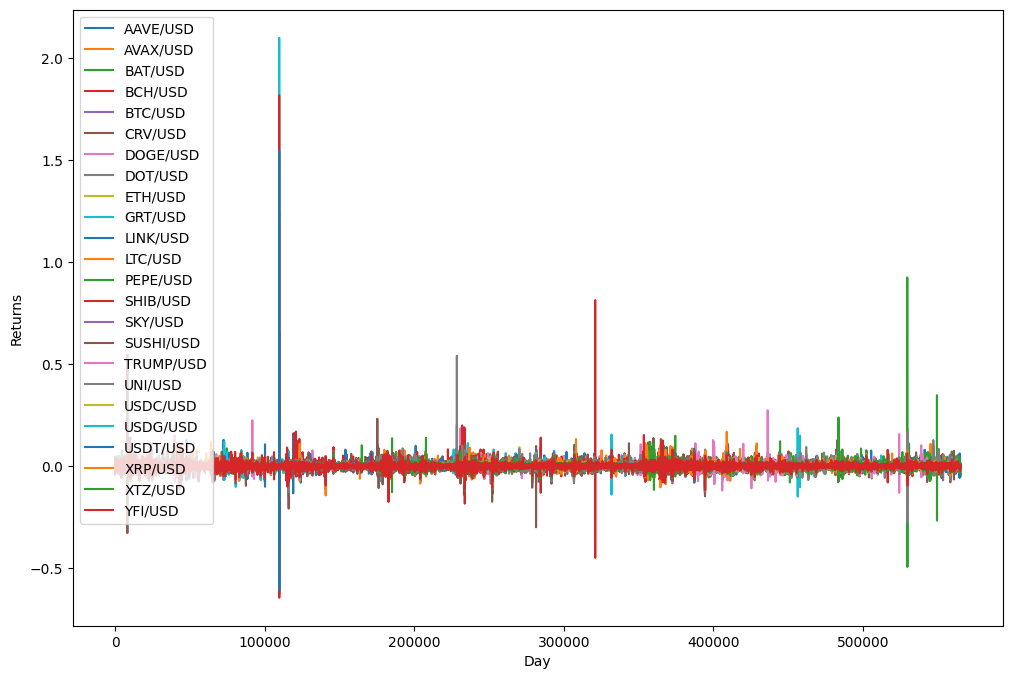

In [78]:
plt.figure(figsize=(12,8))
for i in crypto_basket:
    r = df_crypto[df_crypto["symbol"]==i]["returns"]
    plt.plot(r, label=f"{i}")
    plt.legend()
    plt.xlabel("Day")
    plt.ylabel("Returns")

In [88]:
df_crypto["z_score"] = np.nan
start_day = 5
look_back_win = 4

# Convert timestamp to datetime if not already
df_crypto["timestamp"] = pd.to_datetime(df_crypto["timestamp"])

# Get start date
day_0 = df_crypto["timestamp"].min()
start_date = day_0 + timedelta(days=start_day)

# Filter data
df_start = df_crypto[df_crypto["timestamp"] > start_date].copy()

# Sort by timestamp for efficient rolling calculations
df_start = df_start.sort_values("timestamp")

# Get unique timestamps
unique_times = df_start["timestamp"].unique()

# Pre-calculate lookback windows
for time in unique_times:
    lookback = time - timedelta(days=look_back_win)

    # Get lookback data (vectorized)
    lookback_mask = (df_crypto["timestamp"] >= lookback) & (df_crypto["timestamp"] <= time)
    lookback_returns = df_crypto.loc[lookback_mask, "returns"].dropna()

    # Calculate mean and std once per timestamp
    return_avg_lookback = lookback_returns.mean()
    return_std_lookback = lookback_returns.std()

    # Avoid division by zero
    if return_std_lookback == 0 or pd.isna(return_std_lookback):
        return_std_lookback = 1

    # Calculate z-scores for all symbols at this timestamp (vectorized)
    current_mask = df_start["timestamp"] == time
    current_returns = df_start.loc[current_mask, "returns"]
    z_scores = (current_returns - return_avg_lookback) / return_std_lookback

    # Update main dataframe directly using index
    df_crypto.loc[z_scores.index, "z_score"] = z_scores.values

(-4.0, 4.0)

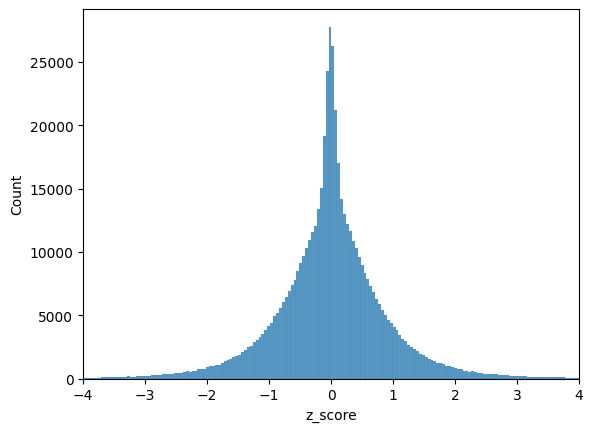

In [92]:
sns.histplot(df_crypto["z_score"])
plt.xlim(-4,4)

## Oil and Gas Cross Sectional Mean Reversion

### Functions

In [216]:
def resample_stock_bars(
    df: pl.DataFrame,
    freq: str,
    timestamp_col: str = "timestamp",
    symbol_col: str = "symbol",
    volatility_window: int = 2,
    market_hours_only: bool = True,
    timezone: str = "UTC",
) -> pl.DataFrame:
    """
    Resample stock bar data from minute/hourly to a specified frequency using Polars.

    Parameters:
    -----------
    df : pl.DataFrame
        DataFrame with stock bar data (must have timestamp and symbol columns)
    freq : str
        Target frequency for resampling. Examples:
        - '6h' for 6 hours
        - '1d' or '24h' for daily
        - '4h' for 4 hours
        - '1w' for weekly
    timestamp_col : str
        Name of the timestamp column (default: "timestamp")
    symbol_col : str
        Name of the symbol column (default: "symbol")
    volatility_window : int
        Frequency to calculate the volatility in days
    market_hours_only : bool
        If True, only use market hours data for resampling (default: True)
    timezone : str
        Target timezone for the output data (default: 'UTC')

    Returns:
    --------
    pl.DataFrame
        Resampled DataFrame with the same structure as input
    """

    # Ensure timestamp is datetime and convert timezone
    df = df.with_columns([
        pl.col(timestamp_col).dt.convert_time_zone(timezone)
    ])

    # Calculate volatility window based on frequency
    def get_volatility_window(freq_str: str, vol_window_days: int) -> int:
        """Convert volatility window from days to number of periods based on frequency"""
        match = re.match(r"(\d+)([A-Za-z]+)", freq_str)
        if not match:
            return vol_window_days

        num = int(match.group(1))
        unit = match.group(2).lower()

        if unit == "d":
            return vol_window_days
        elif unit == "h":
            hours_per_day = 6.5
            total_hours = vol_window_days * hours_per_day
            return int(total_hours / num)
        elif unit == "w":
            return max(1, int(vol_window_days / 7))
        elif unit in ["m", "min"]:
            minutes_per_day = 6.5 * 60
            total_minutes = vol_window_days * minutes_per_day
            return int(total_minutes / num)
        else:
            return vol_window_days

    vol_window_periods = get_volatility_window(freq, volatility_window)

    # Filter for market hours if requested
    if market_hours_only:
        df = df.filter(
            (pl.col(timestamp_col).dt.hour() >= 9) &
            (pl.col(timestamp_col).dt.hour() < 16) &  # Market closes at 4pm
            (pl.col(timestamp_col).dt.weekday() < 5)  # Monday=0, Friday=4
        )

    # Resample using group_by_dynamic per symbol
    resampled = (
        df
        .sort([symbol_col, timestamp_col])
        .group_by(symbol_col)
        .agg([
            pl.col(timestamp_col)
            .dt.truncate(freq)
            .alias(timestamp_col),
            pl.col("open"),
            pl.col("high"),
            pl.col("low"),
            pl.col("close"),
            pl.col("volume"),
            pl.col("trade_count"),
            pl.col("vwap"),
        ])
        .explode([timestamp_col, "open", "high", "low", "close", "volume", "trade_count", "vwap"])
        .group_by([symbol_col, timestamp_col])
        .agg([
            pl.col("open").first(),
            pl.col("high").max(),
            pl.col("low").min(),
            pl.col("close").last(),
            pl.col("volume").sum(),
            pl.col("trade_count").sum(),
            pl.col("vwap").mean(),
        ])
    )

    # Calculate returns and volatility per symbol
    resampled = (
        resampled
        .sort([symbol_col, timestamp_col])
        .with_columns([
            # Calculate returns per symbol
            (pl.col("close").pct_change().over(symbol_col)).alias("returns"),
        ])
        .with_columns([
            # Calculate volatility per symbol
            (
                pl.col("returns")
                .rolling_std(window_size=vol_window_periods)
                .over(symbol_col)
            ).alias("volatility")
        ])
        .sort([timestamp_col, symbol_col])
    )

    return resampled

### Data Querying

In [344]:
from datetime import datetime, timedelta
from pathlib import Path
import polars as pl
import os
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import time

start_date = datetime(2019, 1, 6)
end_date = datetime(2025, 12, 19)

oil_stock_basket = [
    "COP", "EOG", "FANG", "OXY", "EQT", "EXE", "DVN", "TPL", "CTRA", "PR",
    "AR", "OVV", "APA", "RRC", "CRK", "CNX", "CHRD", "MTDR", "MUR", "MGY",
    "GPOR", "CRC", "BSM", "BKV", "CIVI",
]

xle_stocks = [
    "XLE",
    "XOM",
    "CVX",
    "COP",
    "WMB",
    "SLB",
    "EOG",
    "KMI",
    "PSX",
    "VLO",
    "MPC",
    "OKE",
    "BKR",
    "TRGP",
    "EQT",
    "OXY",
    "FANG",
    "EXE",
    "HAL",
    "DVN",
    "CTRA",
    "TPL",
]

api_key = os.getenv("APCA-API-KEY-ID")
secret_key = os.getenv("APCA-API-SECRET-KEY")

client = StockHistoricalDataClient(
    api_key=api_key,
    secret_key=secret_key,
)

# Download in 3-month chunks
chunk_size = timedelta(days=90)
current_start = start_date
all_data = []

while current_start < end_date:
    current_end = min(current_start + chunk_size, end_date)

    print(f"Fetching data from {current_start.date()} to {current_end.date()}...")

    try:
        request_params = StockBarsRequest(
            symbol_or_symbols=xle_stocks,
            timeframe=TimeFrame.Minute,
            start=current_start,
            end=current_end,
            adjustment="all",
        )

        # Get pandas df from Alpaca
        bars_pd = client.get_stock_bars(request_params).df

        # Convert to Polars immediately
        bars_pl = pl.from_pandas(bars_pd, include_index=True)
        all_data.append(bars_pl)

        print(f"Successfully fetched {len(bars_pl)} rows")

        # Be nice to the API
        time.sleep(1)

    except Exception as e:
        print(f"Error fetching chunk: {e}")
        # Save what you have so far
        if all_data:
            pl.concat(all_data).write_parquet(f"partial_data_{current_start.date()}.parquet")
        raise

    current_start = current_end

# Combine all chunks
print("Combining all data...")
combined_df = pl.concat(all_data)

# Sort by symbol first, then timestamp
# This creates better data locality for queries
print("Sorting data...")
combined_df = combined_df.sort(["timestamp", "symbol"])

# Save with optimal settings
data_path_raw = (
    Path.cwd()
    / "data/external"
    / f"bars_data_{start_date.strftime('%Y%m%d')}_to_{end_date.strftime('%Y%m%d')}__{datetime.now().strftime('%Y%m%d')}.parquet"
)

print("Writing to parquet...")
combined_df.write_parquet(
    data_path_raw,
    compression="zstd",  # Good balance of speed and compression
    statistics=True,     # Enable statistics for better query pruning
)
print(f"Saved {len(combined_df)} total rows to {data_path_raw}")

Fetching data from 2019-01-06 to 2019-04-06...
Successfully fetched 537577 rows
Fetching data from 2019-04-06 to 2019-07-05...
Successfully fetched 520883 rows
Fetching data from 2019-07-05 to 2019-10-03...
Successfully fetched 540039 rows
Fetching data from 2019-10-03 to 2020-01-01...
Successfully fetched 528175 rows
Fetching data from 2020-01-01 to 2020-03-31...
Successfully fetched 565397 rows
Fetching data from 2020-03-31 to 2020-06-29...
Successfully fetched 614583 rows
Fetching data from 2020-06-29 to 2020-09-27...
Successfully fetched 547675 rows
Fetching data from 2020-09-27 to 2020-12-26...
Successfully fetched 555182 rows
Fetching data from 2020-12-26 to 2021-03-26...
Successfully fetched 559861 rows
Fetching data from 2021-03-26 to 2021-06-24...
Successfully fetched 557736 rows
Fetching data from 2021-06-24 to 2021-09-22...
Successfully fetched 561597 rows
Fetching data from 2021-09-22 to 2021-12-21...
Successfully fetched 572695 rows
Fetching data from 2021-12-21 to 2022-03

### Data Reading From File

In [215]:
bars = pl.read_parquet(data_path_raw)

df_bars = resample_stock_bars(
    bars,
    timestamp_col="timestamp",
    symbol_col="symbol",
    freq="1h",
    volatility_window=2,    # In Days
    market_hours_only=True,
    timezone='America/New_York',
)

df_bars.filter(pl.col("symbol")=="AR").head(20)

13


shape: (20, 11)
┌────────┬─────────────────┬────────┬───────┬───┬─────────────┬───────────┬───────────┬────────────┐
│ symbol ┆ timestamp       ┆ open   ┆ high  ┆ … ┆ trade_count ┆ vwap      ┆ returns   ┆ volatility │
│ ---    ┆ ---             ┆ ---    ┆ ---   ┆   ┆ ---         ┆ ---       ┆ ---       ┆ ---        │
│ str    ┆ datetime[ns,    ┆ f64    ┆ f64   ┆   ┆ f64         ┆ f64       ┆ f64       ┆ f64        │
│        ┆ America/New_Yor ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│        ┆ k]              ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
╞════════╪═════════════════╪════════╪═══════╪═══╪═════════════╪═══════════╪═══════════╪════════════╡
│ AR     ┆ 2020-01-06      ┆ 2.74   ┆ 2.75  ┆ … ┆ 3065.0      ┆ 2.664757  ┆ null      ┆ null       │
│        ┆ 09:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.615  ┆ 2.64  ┆ … ┆ 5740.0      ┆ 2.594472  ┆ -0.022989 ┆ null       │
│        ┆ 10:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.55   ┆ 2.59  ┆ … ┆ 4519.0      ┆ 2.561105  ┆ 0.007843  ┆ null       │
│        ┆ 11:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.57   ┆ 2.59  ┆ … ┆ 3038.0      ┆ 2.570244  ┆ 0.0       ┆ null       │
│        ┆ 12:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.575  ┆ 2.6   ┆ … ┆ 2296.0      ┆ 2.57652   ┆ 0.005837  ┆ null       │
│        ┆ 13:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.58   ┆ 2.66  ┆ … ┆ 3657.0      ┆ 2.618289  ┆ 0.027079  ┆ null       │
│        ┆ 14:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-06      ┆ 2.655  ┆ 2.68  ┆ … ┆ 6205.0      ┆ 2.637033  ┆ -0.013183 ┆ null       │
│        ┆ 15:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.63   ┆ 2.63  ┆ … ┆ 5371.0      ┆ 2.572274  ┆ -0.007634 ┆ null       │
│        ┆ 09:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.595  ┆ 2.62  ┆ … ┆ 4735.0      ┆ 2.605227  ┆ 0.0       ┆ null       │
│        ┆ 10:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.595  ┆ 2.64  ┆ … ┆ 3068.0      ┆ 2.602198  ┆ -0.017308 ┆ null       │
│        ┆ 11:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.555  ┆ 2.58  ┆ … ┆ 3938.0      ┆ 2.567218  ┆ 0.007828  ┆ null       │
│        ┆ 12:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.575  ┆ 2.64  ┆ … ┆ 2526.0      ┆ 2.601482  ┆ 0.023301  ┆ null       │
│        ┆ 13:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.635  ┆ 2.675 ┆ … ┆ 2860.0      ┆ 2.646009  ┆ 0.009564  ┆ null       │
│        ┆ 14:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-07      ┆ 2.667  ┆ 2.715 ┆ … ┆ 7353.0      ┆ 2.679173  ┆ 0.007443  ┆ 0.014665   │
│        ┆ 15:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-08      ┆ 2.66   ┆ 2.81  ┆ … ┆ 5931.0      ┆ 2.751598  ┆ 0.033582  ┆ 0.014978   │
│        ┆ 09:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-08      ┆ 2.77   ┆ 2.8   ┆ … ┆ 7971.0      ┆ 2.7267351 ┆ -0.028881 ┆ 0.017882   │
│        ┆ 10:00:00 EST    ┆        ┆       ┆   ┆             ┆           ┆           ┆            │
│ AR     ┆ 2020-01-08      ┆ 2.69   ┆ 2.69  ┆

### Research and Analysis

In [338]:
def compute_weights(
    z_scores: pl.DataFrame,
    vol: pl.DataFrame,
    timestamp_col: str = "timestamp",
    rebalance_every: int = 1,
    z_threshold: float = 0.50,
    max_weight: float = 0.05
) -> pl.DataFrame:
    """
    Compute volatility-adjusted, dollar-neutral stat-arb weights using Polars.

    FIXED ISSUES:
    - Removed double-demeaning (z-scores are already demeaned)
    - Fixed normalization logic after clipping
    - Clarified volatility scaling approach
    """

    # Get symbol columns (everything except timestamp)
    symbol_cols = [col for col in z_scores.columns if col != timestamp_col]

    # Get numpy arrays for faster iteration
    timestamps = z_scores[timestamp_col]
    z_array = z_scores.select(symbol_cols).to_numpy()
    vol_array = vol.select(symbol_cols).to_numpy()
    weights_array = np.zeros_like(z_array)

    last_weights = np.zeros(len(symbol_cols))

    for t, _ in enumerate(timestamps):
        # Only rebalance every N bars
        if t % rebalance_every != 0:
            weights_array[t] = last_weights
            continue

        z = np.nan_to_num(z_array[t])
        sigma = np.clip(np.nan_to_num(vol_array[t]), 1e-6, None)

        # Mean reversion signal (negative z-score)
        # Z-scores are ALREADY cross-sectionally demeaned, so don't demean again
        signal = -z

        # Threshold to reduce noise
        inactive = np.abs(signal) < z_threshold
        active = np.abs(signal) > z_threshold


        # Volatility scaling: inverse volatility weighting
        # This makes each position have roughly equal risk contribution
        signal = signal / sigma

        # NOW demean to ensure dollar neutrality
        # (This is different from the original which was double-demeaning)
        signal = signal - np.mean(signal[active])
        signal[inactive] = 0.0

        # Check if we have any signal
        abs_sum = np.sum(np.abs(signal))
        if abs_sum == 0:
            weights_array[t] = np.zeros(len(symbol_cols))
            last_weights = np.zeros(len(symbol_cols))
            continue

        # Normalize to target gross exposure of 1.0 (100% long + 100% short = 2.0 gross)
        signal = signal / abs_sum

        # Apply position caps
        signal = np.clip(signal, -max_weight, max_weight)

        # Renormalize after clipping (recalculate abs_sum!)
        abs_sum_clipped = np.sum(np.abs(signal))
        if abs_sum_clipped > 0:
            signal = signal / abs_sum_clipped

        weights_array[t, :] = signal
        last_weights = signal

    weights_df = z_scores.with_columns([
        pl.Series(col, weights_array[:, i])
        for i, col in enumerate(symbol_cols)
    ])
    # Convert back to Polars DataFrame
    # weights_dict = {timestamp_col: z_scores[timestamp_col]}
    # for i, col in enumerate(symbol_cols):
    #     weights_dict[col] = weights_array[:, i]

    return weights_df


def backtest(
    weights: pl.DataFrame,
    returns: pl.DataFrame,
    timestamp_col: str = "timestamp"
) -> pl.DataFrame:
    """
    Compute portfolio returns from weights and asset returns.

    IMPORTANT: This assumes returns are forward-looking (t to t+1)
    Weights at time t are applied to returns from t to t+1
    """

    # Get symbol columns
    symbol_cols = [col for col in weights.columns if col != timestamp_col]

    # Join weights and returns on timestamp
    combined = weights.join(
        returns.select([timestamp_col] + [pl.col(col).alias(f"{col}_return") for col in symbol_cols]),
        on=timestamp_col,
        how="inner"
    )

    # Calculate portfolio returns: sum of (weight * return) for each symbol
    # Weight at time t × return from t to t+1
    portfolio_return_expr = pl.lit(0.0)
    for col in symbol_cols:
        portfolio_return_expr = portfolio_return_expr + (pl.col(col) * pl.col(f"{col}_return"))

    result = combined.select([
        pl.col(timestamp_col),
        portfolio_return_expr.alias("portfolio_return")
    ])

    return result


def compute_turnover(weights: pl.DataFrame, timestamp_col: str = "timestamp") -> pl.DataFrame:
    """
    Compute turnover as the sum of absolute weight changes.
    """

    symbol_cols = [col for col in weights.columns if col != timestamp_col]

    # First, fill any nulls in the weights with 0
    weights_clean = weights.with_columns([
        pl.col(col).alias(col) for col in symbol_cols
    ])

    # Calculate absolute differences for each symbol and sum
    turnover_expr = pl.sum_horizontal([
        (pl.col(col) - pl.col(col).shift(1)).abs()
        for col in symbol_cols
    ])

    return weights_clean.select([
        pl.col(timestamp_col),
        turnover_expr.alias("turnover")  # Fill first row with 0
    ])


def apply_transaction_costs(
    portfolio_returns: pl.DataFrame,
    weights: pl.DataFrame,
    timestamp_col: str = "timestamp",
    cost_per_turnover: float = 0.0002
) -> pl.DataFrame:
    """
    Apply transaction costs based on turnover.
    """

    turnover = compute_turnover(weights)

    result = (
        portfolio_returns
        .join(turnover, on=timestamp_col, how="inner")
        .with_columns([
            (pl.col("portfolio_return") - pl.col("turnover") * cost_per_turnover).alias("net_return")
        ])
        .select([timestamp_col, "portfolio_return", "turnover", "net_return"])
    )

    return result


def sharpe_ratio(returns: pl.Series, hours_per_year: float = 252 * 6.5) -> float:
    """Calculate annualized Sharpe ratio."""

    if len(returns) == 0:
        return 0.0

    mean_return = returns.mean()
    std_return = returns.std()

    if std_return == 0 or std_return is None:
        return 0.0

    return (mean_return / std_return) * np.sqrt(hours_per_year)


def drawdown(returns: pl.Series) -> pl.Series:
    """Calculate drawdown series."""

    # Calculate cumulative returns
    cum_returns = (1 + returns).cum_prod()

    # Calculate running maximum
    running_max = cum_returns.cum_max()

    # Calculate drawdown
    dd = cum_returns / running_max - 1

    return dd


def max_drawdown(returns: pl.Series) -> float:
    """Calculate maximum drawdown."""

    if len(returns) == 0:
        return 0.0

    dd = drawdown(returns)
    return dd.min()


def backtest_statistics(
    portfolio_returns: pl.DataFrame,
    hours_per_year: float = 252 * 6.5
) -> dict:
    """Calculate comprehensive backtest statistics."""

    returns = portfolio_returns

    if len(returns) == 0:
        return {
            "total_return": 0.0,
            "annualized_return": 0.0,
            "sharpe_ratio": 0.0,
            "volatility": 0.0,
            "max_drawdown": 0.0,
            "win_rate": 0.0,
            "avg_win": 0.0,
            "avg_loss": 0.0,
        }

    total_return = (1 + returns).product() - 1
    n_periods = len(returns)

    stats = {
        "total_return": total_return,
        "annualized_return": ((1 + total_return) ** (hours_per_year / n_periods)) - 1,
        "sharpe_ratio": sharpe_ratio(returns, hours_per_year),
        "volatility": returns.std() * np.sqrt(hours_per_year),
        "max_drawdown": max_drawdown(returns),
        "win_rate": (returns > 0).sum() / len(returns),
        "avg_win": returns.filter(returns > 0).mean() if (returns > 0).sum() > 0 else 0,
        "avg_loss": returns.filter(returns < 0).mean() if (returns < 0).sum() > 0 else 0,
    }

    return stats


# Example usage with your data processing pipeline:
df_partial = df_bars.filter(pl.col("timestamp") < pl.lit("2023-12-01").str.to_date())

# Pivot returns
pivoted_returns = (
    df_partial
    .pivot(values="returns", index="timestamp", on="symbol").fill_null(0)
)

# Calculate z-scores
symbol_cols = [col for col in pivoted_returns.columns if col != "timestamp"]

df_zscores = (
    pivoted_returns
    .select(["timestamp"] + symbol_cols)
    .with_columns([
        pl.concat_list(symbol_cols).list.mean().alias("row_mean"),
        pl.concat_list(symbol_cols).list.std().alias("row_std")
    ])
    .with_columns([
        ((pl.col(col) - pl.col("row_mean")) / pl.col("row_std")).alias(col)
        for col in symbol_cols
    ])
    .select(["timestamp"] + symbol_cols).fill_nan(0)
)

# Pivot volatility
pivoted_vol = (
    df_partial
    .pivot(values="volatility", index="timestamp", on="symbol")
    .select(["timestamp"] + symbol_cols)
)

# Trading loop
trading_metrics = {}
freq_range = np.arange(2, 24, 1, dtype=int)

for rebalance in freq_range:
    weights = compute_weights(
        z_scores=df_zscores,
        vol=pivoted_vol,
        timestamp_col="timestamp",
        rebalance_every=rebalance,
        z_threshold=0.3,
        max_weight=0.15,
    )

    # Backtest
    portfolio_returns = backtest(
        weights,
        pivoted_returns.select(["timestamp"] + symbol_cols),
        timestamp_col="timestamp"
    )

    # Apply transaction costs
    net_returns_df = apply_transaction_costs(
        portfolio_returns,
        weights,
        timestamp_col="timestamp",
        cost_per_turnover=0.001
    )

    # Calculate metrics
    gross_returns = portfolio_returns["portfolio_return"]
    net_returns = net_returns_df["net_return"]

    gross_sharpe = sharpe_ratio(gross_returns)
    net_sharpe = sharpe_ratio(net_returns)

    turnover_df = compute_turnover(weights, timestamp_col="timestamp")
    total_turnover = np.nanmean(turnover_df["turnover"].to_numpy())

    max_dd = max_drawdown(gross_returns)

    trading_metrics[rebalance] = {
        "Gross Sharpe": gross_sharpe,
        "Net Sharpe": net_sharpe,
        "Turnover": total_turnover,
        "Max Drawdown": max_dd,
    }

    print(
        f"Rebalance {rebalance}h | "
        f"Gross Sharpe: {gross_sharpe:.2f} | "
        f"Net Sharpe: {net_sharpe:.2f} | "
        f"Turnover: {total_turnover:.2f} | "
        f"Drawdown: {max_dd:.2f}"
    )

# Convert metrics to DataFrame
df_metrics = pl.DataFrame([
    {"rebalance_freq": k, **v}
    for k, v in trading_metrics.items()
])

Rebalance 2h | Gross Sharpe: -18.03 | Net Sharpe: -20.17 | Turnover: 0.73 | Drawdown: -1.00
Rebalance 3h | Gross Sharpe: -4.74 | Net Sharpe: -5.42 | Turnover: 0.48 | Drawdown: -1.01
Rebalance 4h | Gross Sharpe: 0.48 | Net Sharpe: 0.47 | Turnover: 0.36 | Drawdown: -1.00
Rebalance 5h | Gross Sharpe: -6.44 | Net Sharpe: -7.28 | Turnover: 0.29 | Drawdown: -1.00
Rebalance 6h | Gross Sharpe: -2.73 | Net Sharpe: -3.08 | Turnover: 0.24 | Drawdown: -1.03
Rebalance 7h | Gross Sharpe: -9.50 | Net Sharpe: -9.95 | Turnover: 0.21 | Drawdown: -1.00
Rebalance 8h | Gross Sharpe: 0.51 | Net Sharpe: 0.51 | Turnover: 0.18 | Drawdown: -0.97
Rebalance 9h | Gross Sharpe: 0.51 | Net Sharpe: 0.50 | Turnover: 0.16 | Drawdown: -8.42
Rebalance 10h | Gross Sharpe: -4.14 | Net Sharpe: -4.81 | Turnover: 0.15 | Drawdown: -0.99
Rebalance 11h | Gross Sharpe: -1.79 | Net Sharpe: -1.97 | Turnover: 0.13 | Drawdown: -1.12
Rebalance 12h | Gross Sharpe: 0.52 | Net Sharpe: 0.52 | Turnover: 0.12 | Drawdown: -12.09
Rebalance 13

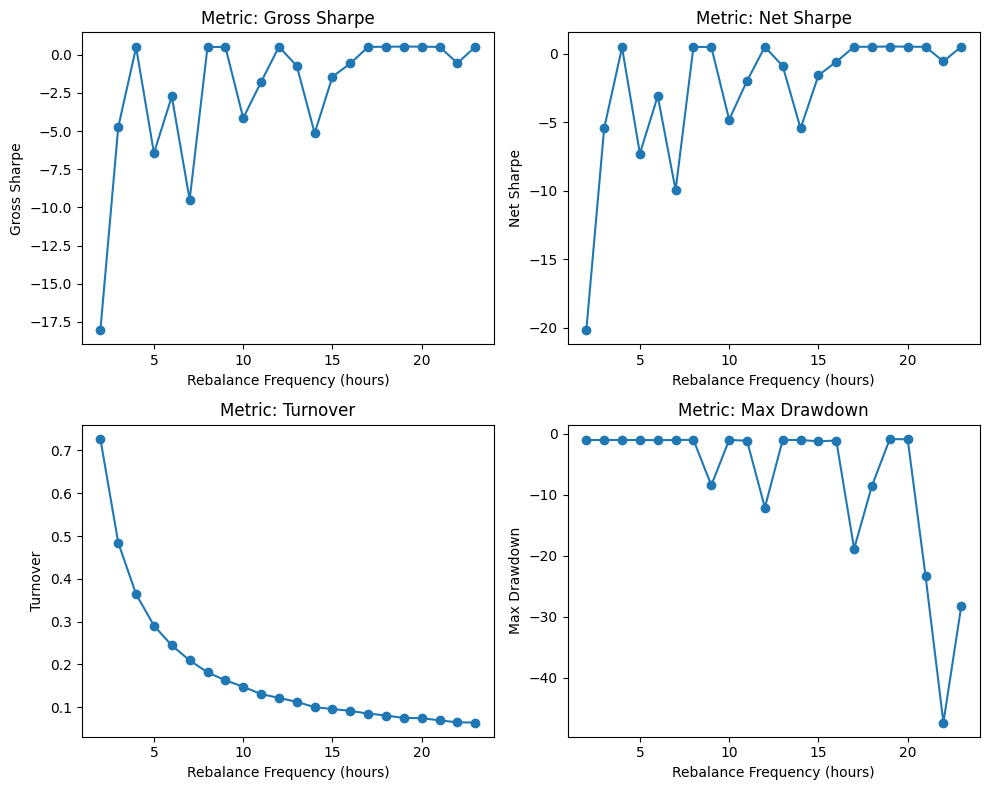

In [339]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10,8))

# Get column names (exclude first column which is rebalance_freq)
metric_cols = [col for col in df_metrics.columns if col != "rebalance_freq"]

for ax, col in zip(axes.flatten(), metric_cols):
    x = df_metrics["rebalance_freq"].to_numpy()

    # if col in ["Gross Sharpe", "Net Sharpe"]:
    #     # Use Polars rolling mean
    #     y = (
    #         df_metrics
    #         .with_columns([
    #             pl.col(col)
    #             .rolling_mean(window_size=5, center=True)
    #             .alias(f"{col}_smoothed")
    #         ])
    #         [f"{col}_smoothed"]
    #         .to_numpy()
    #     )
    # else:
    y = df_metrics[col].to_numpy()

    ax.plot(x, y, marker="o")
    ax.set_title(f"Metric: {col}")
    ax.set_xlabel("Rebalance Frequency (hours)")
    ax.set_ylabel(f"{col}")

fig.tight_layout()
plt.show()

In [174]:
from collections import defaultdict


df_partial = df_bars.filter(pl.col("timestamp") > pl.lit("2023-06-01").str.to_date())

# Pivot returns
pivoted_returns = (
    df_partial
    .pivot(values="returns", index="timestamp", on="symbol").fill_null(0).fill_nan(0)
)

# Calculate z-scores
symbol_cols = [col for col in pivoted_returns.columns if col != "timestamp"]

df_zscores = (
    pivoted_returns
    .select(["timestamp"] + symbol_cols)
    .with_columns([
        pl.concat_list(symbol_cols).list.mean().alias("row_mean"),
        pl.concat_list(symbol_cols).list.std().alias("row_std")
    ])
    .with_columns([
        ((pl.col(col) - pl.col("row_mean")) / pl.col("row_std")).alias(col)
        for col in symbol_cols
    ])
    .select(["timestamp"] + symbol_cols).fill_null(0).fill_nan(0)
)

# Pivot volatility
pivoted_vol = (
    df_partial
    .pivot(values="volatility", index="timestamp", on="symbol")
    .select(["timestamp"] + symbol_cols).fill_null(0).fill_nan(0)
)

# Trading loop
trading_metrics = {}
full_test_stats = {
        "total_return": [],
        "annualized_return": [],
        "sharpe_ratio": [],
        "volatility": [],
        "max_drawdown": [],
        "win_rate": [],
        "avg_win": [],
        "avg_loss": [],
    }
freq_range = np.arange(5, 10, 1)  # Changed back to full range

for rebalance in freq_range:
    weights = compute_weights(
        z_scores=df_zscores,
        vol=pivoted_vol,
        timestamp_col="timestamp",
        rebalance_every=rebalance,
        z_threshold=0.5,
        max_weight=0.10,
    )

    # Backtest
    portfolio_returns = backtest(
        weights,
        pivoted_returns.select(["timestamp"] + symbol_cols),
        timestamp_col="timestamp"
    )

    # Apply transaction costs
    net_returns_df = apply_transaction_costs(
        portfolio_returns,
        weights,
        timestamp_col="timestamp"
    )

    # Calculate metrics
    gross_returns = portfolio_returns["portfolio_return"]
    net_returns = net_returns_df["net_return"]

    gross_sharpe = sharpe_ratio(gross_returns)
    net_sharpe = sharpe_ratio(net_returns)

    turnover_df = compute_turnover(weights, timestamp_col="timestamp")
    total_turnover = np.nanmean(turnover_df["turnover"])

    backtest_stats = backtest_statistics(net_returns)
    for k, v in backtest_stats.items():
        full_test_stats[k].append(v)

    max_dd = max_drawdown(gross_returns)

    trading_metrics[rebalance] = {
        "Gross Sharpe": gross_sharpe,
        "Net Sharpe": net_sharpe,
        "Turnover": total_turnover,
        "Max Drawdown": max_dd,
    }

# Convert metrics dict to DataFrame
df_metrics = pl.DataFrame([
    {"rebalance_freq": k, **v}
    for k, v in trading_metrics.items()
])

print("="*25)
print("Backtest Statistics")
print("="*25)
for key, val in full_test_stats.items():
    print(f"{key}: {np.mean(val):.2f}")

Backtest Statistics
total_return: -0.96
annualized_return: -0.80
sharpe_ratio: -8.76
volatility: 0.20
max_drawdown: -0.96
win_rate: 0.44
avg_win: 0.00
avg_loss: -0.00


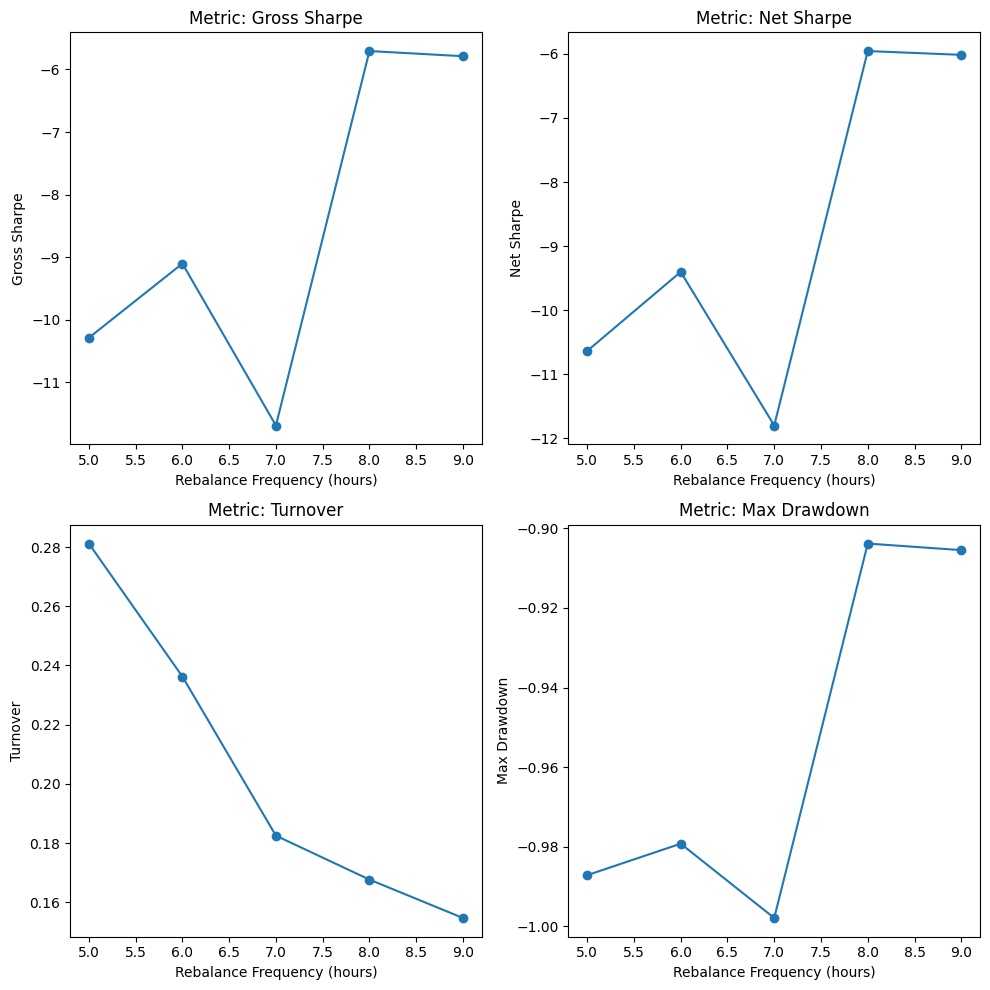

In [175]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Get column names (exclude first column which is rebalance_freq)
metric_cols = [col for col in df_metrics.columns if col != "rebalance_freq"]

for ax, col in zip(axes.flatten(), metric_cols):
    x = df_metrics["rebalance_freq"].to_numpy()
    y = df_metrics[col].to_numpy()

    ax.plot(x, y, marker="o")
    ax.set_title(f"Metric: {col}")
    ax.set_xlabel("Rebalance Frequency (hours)")
    ax.set_ylabel(f"{col}")

fig.tight_layout()
plt.show()